# NuPIC Algorithm API Example

This is a notebook that borrows heavily from the example [discussed here](http://nupic.docs.numenta.org/1.0.5/quick-start/algorithms.html), with my own commentary and thoughts thrown in. I'm a big fan of the spoon-feeding and hand-holding approach to pedagogy, so this may be many times longer than it needs to be for some people. I'm using NuPIC v1.0.5.

### Table of Contents:
* [Encoding Data](#Encoding-Data)
* [Spatial Pooling](#Spatial-Pooling)
 * [Creating the SP](#Creating-the-SP)
 * [Running the SP](#Running-the-SP)
 * [A Note on the Language of "Columns"](#A-Note-on-the-Language-of-"Columns")
* [Temporal Memory](#Temporal-Memory)
 * [Some Quick Vocabulary](#Some-Quick-Vocabulary)
 * [Some Key Points of the TM Algorithm](#Some-Key-Points-of-the-TM-Algorithm)
 * [Creating the TM](#Creating-the-TM)
 * [Running the TM](#Running-the-TM)
* [Classifying SDRs and Getting Predictions](#Classifying-SDRs-and-Getting-Predictions)
* [Detecting Anomalies](#Detecting-Anomalies)
 * [Sidebar - A Consideration of Encoding Resolution](#Sidebar---A-Consideration-of-Encoding-Resolution)
 * [Running Anomaly Detection on a Sine Wave](#Running-Anomaly-Detection-on-a-Sine-Wave)
* [Putting It All Together](#Putting-It-All-Together)

In [1]:
# Preliminary stuff

from __future__ import division, print_function
import numpy as np
import csv
import subprocess
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from nupic.encoders.date import DateEncoder
from nupic.encoders.random_distributed_scalar import RandomDistributedScalarEncoder
from nupic.algorithms.spatial_pooler import SpatialPooler
from nupic.algorithms.temporal_memory import TemporalMemory
from nupic.algorithms.sdr_classifier_factory import SDRClassifierFactory
from nupic.algorithms.anomaly import Anomaly
from nupic.algorithms.anomaly_likelihood import AnomalyLikelihood

%matplotlib inline

# Colormap for TM visualization later
# Not active, Active, Predicted, Winner
#      black,   grey,    yellow,   cyan
colors = [(0,0,0), (0.5,0.5,0.5), (1,1,0), (0,1,1)]
tm_cmap = LinearSegmentedColormap.from_list('tm', colors, N=4)

_INPUT_FILE_PATH = "one_hot_gym_data.csv"

## Encoding Data
We'll use the input data file described [here](http://nupic.docs.numenta.org/1.0.5/quick-start/example-data.html) in detail and used for the [OPF Quick Start](http://nupic.docs.numenta.org/1.0.5/quick-start/opf.html).

Each row of data in this input file is formatted as `M/D/YY H:00,C`, where M = month, D = day, YY = 2-digit year, H = hour, C = energy consumption for that hour. For example, the first record in the data file is `7/2/10 9:00,41.5`.

We'll create three encoders to capture the following:
+ time of day
+ weekend or not
+ energy consumption

To get a handle on how encoders work, you are encouraged to watch a few episodes of HTM School. Namely:  
Episode 1: [Bit Arrays](https://www.youtube.com/watch?v=Ub1fE-bAroA)  
Episode 5: [Scalar Encoding](https://www.youtube.com/watch?v=V3Yqtpytif0)  
Episode 6: [Datetime Encoding](https://www.youtube.com/watch?v=PTYlge2K1G8)

After watching those, look through the [documentation for Encoders](http://nupic.docs.numenta.org/1.0.5/api/algorithms/encoders.html), paying particular attention to understanding the section on `n`, `radius`, and `resolution` for [ScalarEncoders](http://nupic.docs.numenta.org/1.0.5/api/algorithms/encoders.html#scalar-encoders).

To encode the first two, we use a [Date Encoder](http://nupic.docs.numenta.org/1.0.5/api/algorithms/encoders.html#date-encoder), and for the last one we use a [Random Distributed Scalar Encoder](http://nupic.docs.numenta.org/1.0.5/api/algorithms/encoders.html#nupic.encoders.random_distributed_scalar.RandomDistributedScalarEncoder).

In [2]:
timeOfDayEncoder = DateEncoder(timeOfDay=(21,1))     # bucket width = 21, radius = 1 hour
weekendEncoder = DateEncoder(weekend=21)             # bucket width = 21
scalarEncoder = RandomDistributedScalarEncoder(0.88) # resolution = 0.88

With these encoders created, we can loop over each row of data, encode its parts into bit arrays, and concatenate the arrays together to form a complete representation for the next step. Let's see what an encoding looks like. Note: instead of doing this in three steps, we could have used a [MultiEncoder](http://nupic.docs.numenta.org/1.0.5/api/algorithms/encoders.html#multi-encoder), which would have done the encoding and concatenation in one step.

In [3]:
# Make up some fake data
record = ['7/2/10 0:00', '21.2']

# Convert date string into Python date object
dateString = dt.strptime(record[0], "%m/%d/%y %H:%M")
# Convert data value string into float
consumption = float(record[1])

# To encode, we need to provide numpy arrays for the encoders to populate
timeOfDayBits = np.zeros(timeOfDayEncoder.getWidth())
weekendBits = np.zeros(weekendEncoder.getWidth())
consumptionBits = np.zeros(scalarEncoder.getWidth())

# Now we call the encoders to create bit representations for each value
timeOfDayEncoder.encodeIntoArray(dateString, timeOfDayBits)
weekendEncoder.encodeIntoArray(dateString, weekendBits)
scalarEncoder.encodeIntoArray(consumption, consumptionBits)

# Concatenate all these encodings into one large encoding
encoding = np.concatenate((timeOfDayBits, weekendBits, consumptionBits))

# Look at the whole array, then set the print options back to default
np.set_printoptions(threshold=np.nan)
print(encoding.astype("int16"))
np.set_printoptions(threshold=1000)

[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

You can see the continuous sections of on bits for the date encodings. Near the bottom, you can see the "randomly" distributed on bits for the scalar encoder. Another (better?) way to visualize this is to just plot the bitarray.

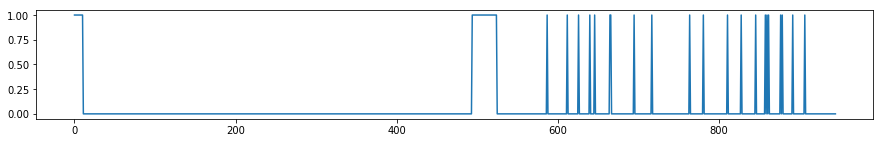

In [4]:
plt.figure(figsize=(15,2))
plt.plot(encoding)
plt.show()

Before moving on, let's write a convenience function to encode data for us.

In [5]:
def encode(file_record):
    dateString = dt.strptime(file_record[0], "%m/%d/%y %H:%M")
    consumption = float(file_record[1])

    timeOfDayBits = np.zeros(timeOfDayEncoder.getWidth())
    weekendBits = np.zeros(weekendEncoder.getWidth())
    consumptionBits = np.zeros(scalarEncoder.getWidth())

    timeOfDayEncoder.encodeIntoArray(dateString, timeOfDayBits)
    weekendEncoder.encodeIntoArray(dateString, weekendBits)
    scalarEncoder.encodeIntoArray(consumption, consumptionBits)

    return np.concatenate((timeOfDayBits, weekendBits, consumptionBits))

## Spatial Pooling
Now that we have data encoded into a bit array with semantic meaning, we can pass each encoding into the Spatial Pooling algorithm, which will create Sparse Distributed Representations (SDRs) of the encoded data. In brief, an SDR can be visualized as a large array filled with zeros and ones, in which the number of zeros vastly outnumbers the number of ones. The ratio of ones to zeros is defined as the *sparsity*. Instead of rephrasing/repeating SDR concepts, it's probably clearer (and highly recommended) to watch the relevant HTM School episodes on SDRs and Spatial Pooling.

Episode 2: [SDR Capacity & Comparison](https://www.youtube.com/watch?v=ZDgCdWTuIzc)  
Episode 3: [SDR Overlap Sets and Subsampling](https://www.youtube.com/watch?v=vU2OZdgBXAQ)  
Episode 4: [SDR Sets & Unions](https://www.youtube.com/watch?v=8WIzIBaLXIs)  
Episode 7: [Spatial Pooling: Input Space & Connections](https://www.youtube.com/watch?v=R5UoFNtv5AU)  
Episode 8: [Spatial Pooling: Learning](https://www.youtube.com/watch?v=rHvjykCIrZM)  
Episode 9: [Boosting](https://www.youtube.com/watch?v=MSwoNAODrgk)  
Episode 10: [Topology](https://www.youtube.com/watch?v=HTW2Q_UrkAw)

### Creating the SP
First, we have to specify parameters for the creation of the **SpatialPooler** instance. One could use the same parameters identified in the [OPF Quick Start](http://nupic.docs.numenta.org/1.0.5/quick-start/opf.html) document's [model parameters](http://nupic.docs.numenta.org/1.0.5/quick-start/example-model-params.html) (see the **spParams** section), but we're here to learn and make this thing our own. As such, let's look at the defining SP parameters and understand what each does (most of this will make zero sense if you haven't watched the HTM School videos...possibly several times). Descriptions below have been copied from [here](http://nupic.docs.numenta.org/1.0.5/api/algorithms/spatial-pooling.html).

**inputDimensions** *Default (32, 32)*  
A sequence representing the dimensions of the input vector. Format is (height, width, depth, ...), where each value represents the size of the dimension.  
**columnDimensions** *Default (64, 64)*  
A sequence representing the dimensions of the columns in the SP region. Format is (height, width, depth, ...), where each value represents the size of the dimension.  
**potentialRadius** *Default 16*  
This parameter determines the extent of the input that each column can potentially be connected to. This can be thought of as the input bits that are visible to each column, or a 'receptiveField' of the field of vision. A large enough value will result in 'global coverage', meaning that each column can potentially be connected to every input bit. A column will have a max square potential pool with sides of length 2 * potentialRadius + 1.  
**potentialPct** *Default 0.5*  
The percent of the inputs, within a column's receptive field that's available for potential synapses. This parameter is used to give each column a unique potential pool when a large potentialRadius causes overlap between the columns. At initialization time we choose *(2 * potentialRadius + 1)^(inputDimensions) * potentialPct* input bits to comprise the column’s potential pool.  
**globalInhibition** *Default False*  
If true, then during inhibition phase the winning columns are selected as the most active columns from the region as a whole. Otherwise, the winning columns are selected with respect to their local neighborhoods. Using global inhibition boosts performance x60.  
**localAreaDensity** *Default -1.0*  
The desired density of active columns within a local inhibition area (the size of which is set by the internally calculated inhibitionRadius, which is in turn determined from the average size of the connected potential pools of all columns). The inhibition logic will insure that at most N columns remain ON within a local inhibition area, where *N = localAreaDensity * (total number of columns in inhibition area)*.  
**numActiveColumnsPerInhArea** *Default 10.0*  
An alternate way to control the density of the active columns. If numActiveColumnsPerInhArea is specified then localAreaDensity must be less than 0, and vice versa. When using numActiveColumnsPerInhArea, the inhibition logic will insure that at most 'numActiveColumnsPerInhArea' columns remain ON within a local inhibition area (the size of which is set by the internally calculated inhibitionRadius, which is in turn determined from the average size of the connected receptive fields of all columns). When using this method, as columns learn and grow their effective receptive fields, the inhibitionRadius will grow, and hence the net density of the active columns will decrease. This is in contrast to the localAreaDensity method, which keeps the density of active columns the same regardless of the size of their receptive fields. This number divided by our total number of columns gives the sparsity.  
**stimulusThreshold** *Default 0*  
This is a number specifying the minimum number of synapses that must be on in order for a columns to turn ON. The purpose of this is to prevent noise input from activating columns. Specified as a percent of a fully grown synapse.  
**synPermInactiveDec** and **synPermActiveInc** *Defaults: 0.008 and 0.05*  
The amounts by which inactive and active synapses' permanences are changed each round. Specified as a percent of a fully grown synapse. Note they grow ~>10x faster than they degrade with the default settings.  
**synPermConnected** *Default 0.1*  
Any synapse whose permanence value is above the connected threshold is a "connected synapse", meaning it can contribute to the cell's firing.  
**minPctOverlapDutyCycle** *Default 0.001*  
A number between 0 and 1.0, used to set a floor on how often a column should have at least stimulusThreshold active inputs. Periodically, each column looks at the overlap duty cycle of all other columns within its inhibition radius and sets its own internal minimal acceptable duty cycle to: minPctDutyCycleBeforeInh * max(other columns' duty cycles). On each iteration, any column whose overlap duty cycle falls below this computed value will get all of its permanence values boosted up by synPermActiveInc. Raising all permanences in response to a sub-par duty cycle before inhibition allows a cell to search for new inputs when either its previously learned inputs are no longer ever active, or when the vast majority of them have been "hijacked" by other columns.  
**dutyCyclePeriod** *Default 1000*  
The period used to calculate duty cycles. Higher values make it take longer to respond to changes in boost or synPerConnectedCell. Shorter values make it more unstable and likely to oscillate.  
**boostStrength** *Default 0.0*  
Boosting encourages columns to have similar activeDutyCycles as their neighbors, which will lead to more efficient use of columns. However, too much boosting may also lead to instability of SP outputs. Can be any number >= 0.0.  
**seed** *Default -1*  
Random number generator seed  
**spVerbosity** *Default 0*  
spVerbosity level: 0, 1, 2, or 3.  
**wrapAround** *Default True*  
Determines if inputs at the beginning and end of an input dimension should be considered neighbors when mapping the columns to inputs.

In [6]:
encodingWidth = timeOfDayEncoder.getWidth() + weekendEncoder.getWidth() + scalarEncoder.getWidth()

sp = SpatialPooler(
    inputDimensions = (encodingWidth,),
    columnDimensions=(2048,),
    potentialRadius = encodingWidth, # -> let every column see every input cell
    potentialPct = 0.85,             # -> but use only a random 85% of them
    globalInhibition = True,
    localAreaDensity = -1.0,
    numActiveColumnsPerInhArea = 40.0, # this / total column number = sparsity (40/2048 ~ 2%)
    stimulusThreshold = 0,
    synPermInactiveDec = 0.005,  # I've set the synapse growth-to-degradation
    synPermActiveInc = 0.04,     # ratio to a little less than 10
    synPermConnected = 0.1,
    minPctOverlapDutyCycle = 0.001,
    dutyCyclePeriod = 100,
    boostStrength = 0.0,
    seed = 42,
    spVerbosity = 0,
    wrapAround = False
)

### Running the SP
After we've created the **SpatialPooler** instance, we can pass encoded data to it via its `compute()` function.

In [7]:
# Create an array to represent active columns. This is populated by the
# compute method. It must have the same dimensions as the Spatial Pooler.
activeColumns = np.zeros(2048)

# Execute Spatial Pooling algorithm over input space.
sp.compute(encoding, True, activeColumns)
activeColumnIndices = np.nonzero(activeColumns)[0]

print(activeColumnIndices)

[  15  127  212  213  318  438  444  468  531  591  606  630  646  717  720
  756  851  861  870  883  909 1014 1112 1181 1190 1219 1541 1568 1611 1696
 1776 1784 1842 1846 1850 1885 1919 1943 1962 2030]


Instead of looking at the bit arrays, let's create a nice 2-D visualization to view the encoder output and the SDR.

In [8]:
def showSDR(file_record):
    encoding = encode(file_record)
    
    activeCols = np.zeros(sp.getColumnDimensions())
    sp.compute(encoding, False, activeCols)
    nEN = int(np.math.ceil(encodingWidth**0.5))
    nSP = int(np.math.ceil(sp.getColumnDimensions()[0]**0.5))
    fig, ax = plt.subplots(1,2,figsize=(15,8))
    imgEN = np.ones(nEN**2)*-1
    imgEN[:len(encoding)] = encoding
    imgSP = np.ones(nSP**2)*-1
    imgSP[:len(activeCols)] = activeCols
    ax[0].imshow(imgEN.reshape(nEN,nEN))
    ax[1].imshow(imgSP.reshape(nSP,nSP))
    for a in ax:
        a.tick_params(axis='both',which='both',bottom=False,labelbottom=False, left=False, labelleft=False)
    ax[0].set_title('Encoder output', fontsize=20)
    ax[1].set_title('SDR', fontsize=20)
    ax[0].set_ylabel("{0}  --  {1}".format(*file_record), fontsize=20)
    plt.show()

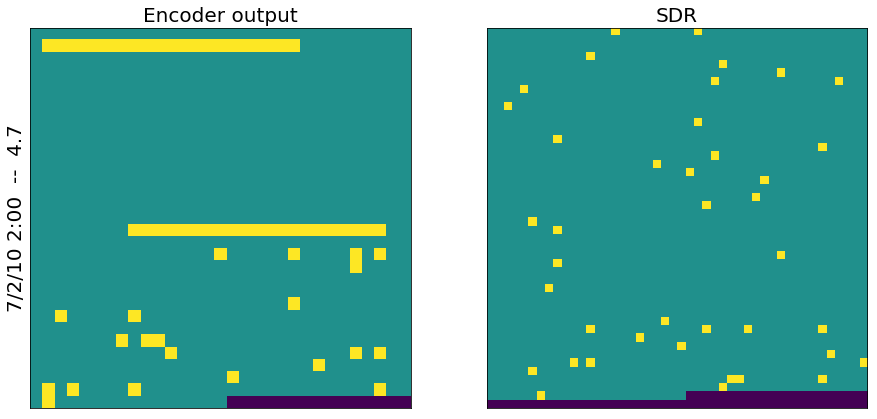

In [9]:
showSDR(['7/2/10 2:00',4.7])

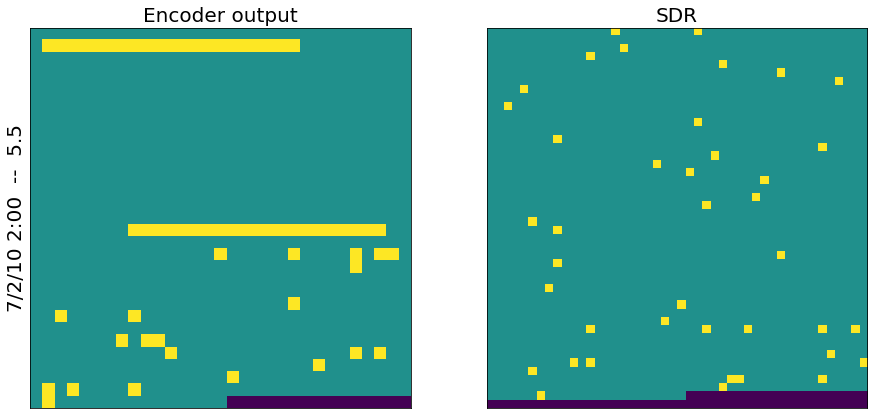

In [10]:
showSDR(['7/2/10 2:00', 5.5])

Very nice. We can use this to see how the encoding and SDR changes with different inputs. For an extra treat, you can use the code below (on Linux) to make GIFs for the first N records of data.

In [ ]:
N = 30

# dimensions needed to make 2d square figures
nEN = int(np.math.ceil(encodingWidth**0.5))
nSP = int(np.math.ceil(sp.getColumnDimensions()[0]**0.5))

fig1, ax1 = plt.subplots(1,2, figsize=(15,8))
fig2, ax2 = plt.subplots(2,1, figsize=(15,4))

fin = open(_INPUT_FILE_PATH,'r')
reader = csv.reader(fin)
reader.next()
reader.next()
reader.next()
for iframe in range(N):
    encoding = encode(reader.next())

    sp.compute(encoding, True, activeColumns)
    activeColumnIndices = np.nonzero(activeColumns)[0]

    for ax in ax1:
        ax.clear()
    for ax in ax2:
        ax.clear()
    imgEN = np.ones(nEN**2)*-1
    imgEN[:len(encoding)] = encoding
    imgSP = np.ones(nSP**2)*-1
    imgSP[:len(activeColumns)] = activeColumns
    ax1[0].imshow(imgEN.reshape(nEN,nEN))
    ax1[1].imshow(imgSP.reshape(nSP,nSP))
    for ax in ax1:
        ax.tick_params(axis='both',which='both',bottom=False,labelbottom=False, left=False, labelleft=False)
    ax1[0].set_title("Encoder output", fontsize=20)
    ax1[1].set_title("SDR", fontsize=20)
    ax1[0].set_ylabel("Record " + str(iframe), fontsize=16)
    ax2[0].plot(activeColumns)
    ax2[1].plot(encoding)
    for ax in ax2:
        ax.tick_params(axis='both',which='both',bottom=False,labelbottom=False, left=False, labelleft=False)
    ax2[0].set_ylabel("SDR".format(iframe))
    ax2[1].set_ylabel("Encoder\noutput")
    ax2[1].set_xlabel("Record " + str(iframe), fontsize=16)
    fig1.savefig("encsdr2d{0:04d}.png".format(iframe))
    fig2.savefig("encsdr1d{0:04d}.png".format(iframe))


fin.close()
plt.show()
subprocess.call("convert -delay 15 -resize 1280x960 encsdr1d*.png sdr1d.gif", shell=True)
subprocess.call("convert -delay 15 -resize 1280x960 encsdr2d*.png sdr2d.gif", shell=True)
subprocess.call("mkdir gifdir", shell=True)
subprocess.call("mv *.png gifdir/", shell=True)

### A Note on the Language of "Columns"
At this point, you may be confused by the word "column". In the SDRs above, you see individual cells lit up. These are actually columns. In short, you are looking at an overhead view of the SDR. Imagine a stack of cells underneath. That stack comprises the column.

Also, as you watch the HTM School episodes and get deeper into HTM theory, you'll hear/read about mini-columns. Mini-columns make up a cortical column, as shown in [this nice HTM theory cheat sheet](https://discourse.numenta.org/t/htm-cheat-sheet/828). So what does someone mean when they just say "column?" Well, it depends on the context, but usually they are talking about mini-columns in the Spatial Pooler. Indeed, this is what is meant in this notebook unless specified otherwise.

## Temporal Memory
The **TemporalMemory** algorithm works within the active columns created by the **SpatialPooler**. You give it a list of active column indices, and it builds connections between active column cells of consecutive inputs to learn what follows what. Again, you will be greatly served by watching the relevant HTM School episodes:  
Episode 11: [Temporal Memory Part 1](https://www.youtube.com/watch?v=UBzemKcUoOk)  
Episode 12: [Temporal Memory Part 2](https://www.youtube.com/watch?v=1OhY_u3NjdM)

#### Some Quick Vocabulary
Each **cell** in a **column** will connect to other cells via **synapses** of **segments**. A cell can have many segments, each of which is a collection of synapses. Each synapse connects to another cell. To see an example, check out [minute 11:00 in HTM School episode 11](https://youtu.be/UBzemKcUoOk?t=660). Question to consider:  Can (or should) a cell have a segment with a synapse that attaches to itself? I'm not sure myself, but I doubt it's a good idea.

A **potential synapse** is one whose permanence level is below the threshold to be considered **connected**. While technically a synapse that doesn't exist could be considered as potential, the jargon here does not include it as such.

#### Some Key Points of the TM Algorithm
- Segments are created when an active cell in one step has no segments that connect to active cells from the previous step. This creation is performed so that the next time the previous step occurs, the active cells will predict the current step by putting the current active cell into a predictive state.

- If a predictive cell becomes active on the next step, then the segment that made that prediction will have its synapses updated (those that contributed to the prediction will be reinforced, those that didn't contribute will be punished). If a predictive cell does *not* become active on the next step, then the segment that made that prediction will be punished by punishing the synapses that contributed to the prediction.

- If a column becomes active, a **winner cell** must be chosen.
> Scenario 1 -- If there are predictive cells, all of them are made the winner cells.  
Scenario 2 -- If no cells are predictive, we see if any segments are "**matching**". "Matching" means that the segment *almost* made its cell predictive. That is, it had less than the needed number of active synapses to make its cell predictive, but more than some minimum. In other words, it's likely the segment would have made the cell predictive had its synapses had higher permanences. In that case, the cell with the best matching segment is declared the winner.  
Scenario 3 -- If no cells are predictive, and no segments are matching, the cell with the fewest number of segments is declared the winner


### Creating the TM
In the [Algorithm API Quick Start](http://nupic.docs.numenta.org/1.0.5/quick-start/algorithms.html), there is some contradictory information in creating the TM. There is reference to using the [model parameters](http://nupic.docs.numenta.org/1.0.5/quick-start/example-model-params.html) (see the **tmParams** section) as specified in the [OPF Quick Start](http://nupic.docs.numenta.org/1.0.5/quick-start/opf.html), but using these parameters implements a BacktrackingTM (a species of TM designed with extra bells and whistles for anomaly detection). The code itself actually implements a regular TM. Moreover, [this post](https://discourse.numenta.org/t/my-analysis-on-why-temporal-memory-prediction-doesnt-work-on-sequential-data/3141/29) mentions that Numenta didn't move forward with the backtracking model and [this post](https://discourse.numenta.org/t/is-there-a-good-write-up-re-differences-between-cpp-and-tm-cpp/4249/4) mentions that backtracking is no longer being developed, BUT the backtracking model performs better for anomaly detection tasks.

Here we'll use the regular TM since it's supported. If you feel so inclined, you could try substituting the BacktrackingTM and explore the results.

#### TM parameters

Just like the SP, we should review the parameters for TM to improve our understanding. Copied from [here](http://nupic.docs.numenta.org/1.0.5/api/algorithms/sequence-memory.html).

**columnDimensions** - (list or tuple) - Dimensions of the column space. *Default [2048]*  
**cellsPerColumn** - (int) - Number of cells per column. *Default 32*  
**activationThreshold** - (int) - If the number of active connected synapses on a segment is at least this threshold, the segment is active. *Default 13*  
**initialPermanence** - (float) - Initial permanence of a new synapse. *Default 0.21*  
**connectedPermanence** - (float) - If the permanence value for a synapse is greater than this value, it is said to be connected. *Default 0.5*  
**minThreshold** - (int) - If the number of potential synapses active on a segment is at least this threshold, it is said to be “matching” and is eligible for learning. In other words, this is the minimum number of active synapses for a segment to be considered during the search for the best-matching segments. Note that this value cannot be greater than **activationThreshold**, or no segments would ever be matching. *Default 10*  
**maxNewSynapseCount** - (int) - The maximum number of synapses added to a segment during learning. *Default 20*  
**permanenceIncrement** - (float) - Amount by which permanences of synapses are incremented during learning. *Default 0.1*  
**permanenceDecrement** - (float) - Amount by which permanences of synapses are decremented during learning. *Default 0.1*  
**predictedSegmentDecrement** - (float) - Amount by which segments are punished for incorrect predictions. *Default 0.0*  
**seed** - (int) - Seed for the random number generator. *Default 42*  
**maxSegmentsPerCell** - (int) - The maximum number of segments per cell. *Default 255*  
**maxSynapsesPerSegment** - (int) - The maximum number of synapses per segment. *Default 255*

#### Note from Numenta
**predictedSegmentDecrement**: A good value is just a bit larger than (permanenceIncrement * the column-level sparsity). So, if column-level sparsity is 2% and permanenceIncrement is 0.01, this parameter should be something like 4% * 0.01 = 0.0004).

#### Note from Me
If you've watched the HTM School episodes on TM, you'll know that **cellsPerColumn** is important in determining how many contexts/sequences each datum can be a part of. Given the two sequences, "No soup for you" and "Would you like soup or salad", soup has two contexts. To predict what comes after "soup", you'd need a representation that means it is in the context of "No" and another representation that means it is in the context of "Would you like". It the first context, you'd predict "for", in the second, "or". My understanding is that the number of possible contexts is equal to $cellsPerColumn^{numActiveCols}$.

#### A Very Important Thing You Should Know About SP's and TM's Learning Simultaneously
In short, if the SP is still learning, the TM will be trying to learn on (possibly) inconsistent representations (depending on how your SP is set up). To see why this might give you trouble, consider an example where you can't read and I'm helping you memorize a written speech.

I (the SP) am translating the written words (the encoding) into speech (SDRs) for you (the TM) to memorize. The speech is long, so we'll have to do many repetitions. If, during one of the repetitions, I suddenly start using a different language for some of the words, you're going to be confused; those words weren't part of the speech. Well, they are, but I just chose to translate them differently. In other words, the input encodings haven't changed, but the SP changed the SDRs to represent them, and the TM has never seen these SDRs before.

In summary, it is probably preferable to let the SP learn on the data domain for a while to let it settle on how it will represent the input data. Once that's achieved, you can turn off its learning and start training the TM.

#### Pure Speculation
The previous idea is fun to think about in the context of adults learning a new domain of knowledge (learn the jargon-concepts first and then the sequence learning can really get going). Babies (unfortunately?) have their SPs and TMs learning simultaneously?

In [11]:
tm = TemporalMemory(
    columnDimensions = (2048,), # Must be the same dimensions as the SP
    cellsPerColumn = 16,        # reduced from default
    activationThreshold = 16,   # increased from default
    initialPermanence = 0.55,   # make a synapse connect when it's created
    connectedPermanence = 0.5,
    minThreshold = 12,          # increased from default
    maxNewSynapseCount = 20,
    permanenceIncrement = 0.1,
    permanenceDecrement = 0.02, # 1/5th of default to slow down "forgetting"
    predictedSegmentDecrement = 0.0,
    seed = 42,
    maxSegmentsPerCell = 128,   # reduced from default
    maxSynapsesPerSegment = 32  # reduced from default
)
# Choose value based on Numenta's recommendation
tm.predictedSegmentDecrement = sp.getNumActiveColumnsPerInhArea() / sp.getColumnDimensions()[0] * tm.permanenceIncrement;

### Running the TM
Given a SpatialPooler instance SP, and a TemporalMemory instance TM, we can run `TM.compute()` using the active columns presented by `SP.compute()`. Then we can call `TM.getActiveCells()` to return the indices of the active cells within the SP. All active cells will fall within, you guessed it, active columns. We can also get predictive cells by calling `TM.getPredictiveCells()`, which returns an array of indices of cells in a depolarized, or predictive, state.

But first, I want to demonstrate some simple learning. I'm going to send the TM a sequence (A,B,C) a few times and watch as it learns. It should take one pass because of the TM parameters chosen above; the **initialPermanence** is 0.55, the **connectedPermanence** is 0.5, and the **permanenceIncrement** is 0.1. So it should go something like this:  
>Step1 : pass in A : columns burst, winner cells chosen, no predicted cells  
Step2 : pass in B : same as Step1, and additionally creates segments with synapses from winner cells to last step's winner cells  
Step3 : pass in C : same as Step2  
Step4 : send TM a reset  
Step5 : pass in A : same as Step1, except predicts B winner cells from Step2 because winner cells from Step1 are active  
Step6 : pass in B : predicted B cells are activated, predicts C winner cells from Step3  
Step7 : pass in C : predicted C cells are activated, predicts nothing  

In the images generated below, bursting columns are grey, predicted cells are yellow, and active/winner cells are blue. Be warned that the pictures generated probably will not show all the active columns/cells, but rest assured that if you check the length of the activeColumnIndices variable, you'll find 40 active columns. It's just my image making skill is lacking. Regardless, the point here though is to show the process of bursting during initial learning, followed by the TM predicting B and C correctly on the second pass.

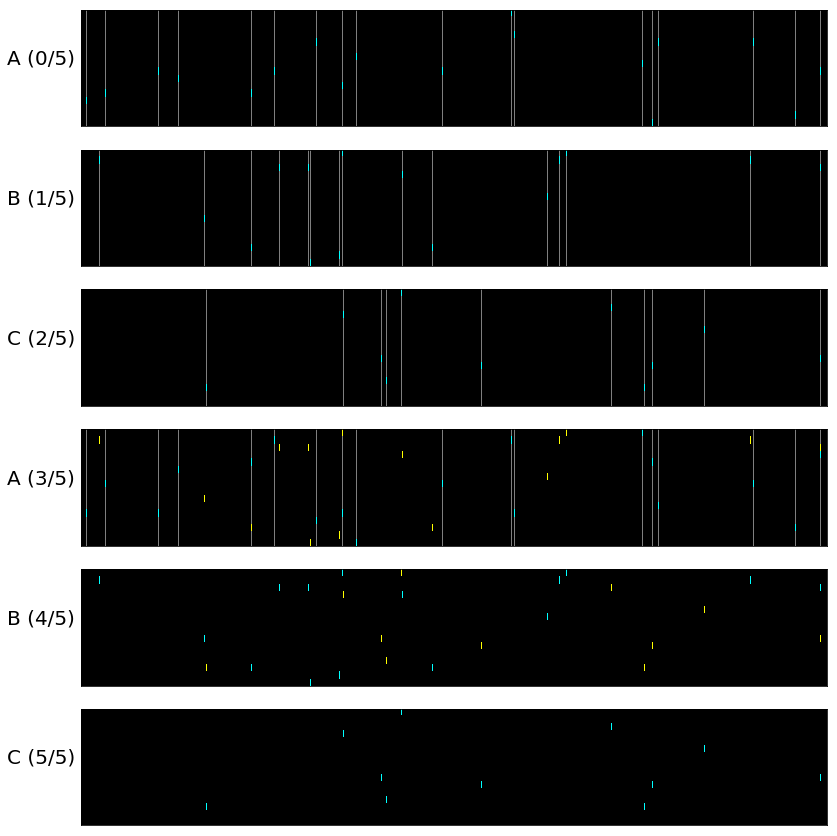

In [12]:
# Semantically close
# records = [('7/2/10 0:00', '10.2'),
#            ('7/2/10 1:00', '21.4'),
#            ('7/2/10 2:00', '30.7')] * 2

# Semantically far apart
records = [('7/2/10 0:00', '5.2'),
           ('7/4/10 18:00', '20.7'),
           ('7/2/10 12:00', '86.4')] * 2

nPlots = len(records)
fig, ax = plt.subplots(nPlots,1,figsize=(15, nPlots*2.5))

for i,record in enumerate(records):

    sp.compute(encode(record), False, activeColumns)
    activeColumnIndices = np.nonzero(activeColumns)[0]
    tm.compute(activeColumnIndices, learn=True)

    imgTM = np.zeros(tm.getCellsPerColumn()*tm.getColumnDimensions()[0])
    imgTM[tm.getActiveCells()] = 1
    imgTM[tm.getPredictiveCells()] = 2
    imgTM[tm.getWinnerCells()] = 3
    ax[i].imshow(imgTM.reshape((tm.getCellsPerColumn(), tm.getColumnDimensions()[0]), order='F'), cmap=tm_cmap)
    ax[i].set_aspect(20)
    ax[i].set_ylabel('{} ({}/{})'.format({0:'A',1:'B',2:'C'}[i % 3],i,len(records)-1),fontsize=20,rotation=0,labelpad=40)
    ax[i].tick_params(axis='both',which='both',bottom=False,labelbottom=False, left=False, labelleft=False)

    if i % 3 == 2:
        tm.reset()

plt.show()

#### Variations
If we hadn't sent a reset in Step4, then in Step5 NEW winner cells would be chosen that represent A in the context of {A,B,C}. This results in some (possibly) strange behavior when you're trying to learn repeating sequences. [Other people have noticed this](https://discourse.numenta.org/t/my-analysis-on-why-temporal-memory-prediction-doesnt-work-on-sequential-data/3141/5).

If I were to make the **initialPermanence** = 0.45, it would take two learning passes; once to make the segments, and once to increment the permanence levels over the connection threshold. This is counter to the [BAMI](https://numenta.com/resources/biological-and-machine-intelligence/) psuedocode, which alleges that initial connections also get fed through the reinforcement/learning phase (i.e. an initial connection is created and immediately gets an increment in its permanence); if this were the case, setting **initialPermanence** > **connectedPermanence** - **permanenceIncrement** would result in the sequence being learned in one pass.

If I make the records more semantically close, one pass doesn't appear to be enough to learn C in the context of {A,B}. Perhaps you, dear reader, will understand why this happens. Sadly, I could not.

## Classifying SDRs and Getting Predictions

At this point, you've got a SP and a TM, and the system is learning and making predictions. Unfortunately, those predictions are represented by the TM as a set of predictive cells in the SP columns. In other words, the prediction is in the form of an SDR. So how do we translate SDRs into human-understandable numbers or categories?

NuPIC uses non-biological methods of classification. There are [two available](http://nupic.docs.numenta.org/1.0.5/api/algorithms/classifiers.html), but the current go-to method is the SDRClassifier. Under the hood, the SDRClassifier is just a neural network, and though some HTM folks may clutch their pearls at the idea of besmirching the HTM framework by using such a technique, [it is currently what is used](https://www.youtube.com/watch?v=iUrqokeC7ec).

The use of a neural network combines the two actions of classification and prediction into one object. To get a sense of how it does this, consider having a sequence of data ($D_1$, $D_2$, ..., $D_N$) that you're passing through an encoder to get encodings ($E_1$, $E_2$, ..., $E_N$). The SP creates SDRs ($S_1$, $S_2$, ..., $S_N$) out of these encodings, and the TM watches the sequence happen, creating and modifying distal segments along the way. Using these segments, the TM decides what set of cells should be active ($A_1$, $A_2$, ..., $A_N$) for each SDR of the SP. These sets of active cells are themselves SDRs, and *these* are the SDRs that we'll use with the SDRClassifier.

To facilitate classification, the SDRClassifier connects encodings and SDRs. It does this by using the SDR as the input to the neural net and (roughly) the encoding as the output. If you want to know the gritty details, I suggest checking out [this forum post](https://discourse.numenta.org/t/how-the-sdr-classifier-works/1481) and looking at [the source code](https://github.com/numenta/nupic/blob/master/src/nupic/algorithms/sdr_classifier.py).

To facilitate prediction, the SDRClassifier decides *which* encodings to connect to *which* SDRs. This decision is made via the **steps** parameter. By setting this parameter, say to $X$, you are telling the SDRClassifier to connect the $E_{N+X}$ encoding to the $A_N$ SDR. In this way, your SDRClassifier becomes a model classifies the $A_N$ SDR as a $E_{N+X}$ encoding. In effect, this makes the SDRClassifier act like a prediction model, predicting what encoding you'll see $X$ steps later in the sequence after seeing the current SDR.

**Extra Credit** - Why not just use the SDRs from the SP? My guess is that an $A$ SDR provides more information than an $S$ SDR. Remember, the $A$ SDR is a specific set of active cells within $S$. This means that context information is included in $A$ but not in $S$. And as we know from learning about TM, context information is very important in deciding what will come next in a sequence.

#### Another Very Important Thing You Should Know
It's the same idea as last time. In short, if you're training a classifier on a TM that hasn't "settled" yet, it may get confused. This time though, it shouldn't matter as much. If you train the classifier on noise, it shouldn't learn anything, meaning it won't become biased. Once the classifier starts getting trained on data with real patterns, it should start to converge to those patterns.

### Running the Classifier
In order to call `compute()` on a classifier, we need to pass it both the actual value we want to predict and the bucket index reported by its encoder. This will allow the encoder to classify predictions into a previously seen value. Before running a test on some made-up data, let's look at the SDR Classifier parameters (copied from [here](http://nupic.docs.numenta.org/1.0.5/api/algorithms/classifiers.html)).

**steps** - (list) - Sequence of the different steps of multi-step predictions to learn *Default [1]*  
**alpha** - (float) - The alpha used to adapt the weight matrix during learning. A larger alpha results in faster adaptation to the data. *Default 0.001*  
**actValueAlpha** - (float) - Used to track the actual value within each bucket. A lower actValueAlpha results in longer term memory *Default 0.3*  
**verbosity** - (int) - verbosity level, can be 0, 1, or 2 *Default 0*

In [14]:
# Try varying the number of steps and alpha
num_of_steps = 1
alpha = 0.01

classifier = SDRClassifierFactory.create(steps=[num_of_steps], alpha=alpha)

# Make up some things to classify
vals = [4.5, 23.4, 56.7]   # made up values
bucketIdx = [1, 5, 9]      # made up bucket indices
cellIdx = []               # made up active cells indices from the TM
cellIdx.append([1449, 2009, 602, 1810])
cellIdx.append([901, 570, 377, 2005])
cellIdx.append([87, 516, 1270, 232])

# Let the classifier learn them over N cycles
# (if you've done any work with gradient descent, you'll know that to
#  get good predictions, you will need a larger N for a smaller alpha)
N = 1000
for i in range(3*N):
    classifier.compute(recordNum = i, patternNZ = cellIdx[i%3],
                       classification={"bucketIdx": bucketIdx[i%3], "actValue":vals[i%3]},
                       learn=True, infer=False)

print("Sequence trained on: {{{0}, {1}, {2}}}".format(*vals))
print("Predicting what comes {} steps later\n".format(num_of_steps))
for j in range(3):
    result = classifier.compute(recordNum = None, patternNZ = cellIdx[j],
                                classification={"bucketIdx": bucketIdx[j], "actValue":vals[j]},
                                learn=False, infer=True)

    a = sorted(zip(result[num_of_steps], result["actualValues"]), reverse=True)[:3]
    print("If you see {}, {} steps later you'll see:".format(vals[j], num_of_steps))
    for x in a:
        print("\t{0:.2f}% chance of seeing {1}".format(x[0]*100, x[1]))

Sequence trained on: {4.5, 23.4, 56.7}
Predicting what comes 1 steps later

If you see 4.5, 1 steps later you'll see:
	87.06% chance of seeing 23.4
	3.23% chance of seeing 56.7
	3.23% chance of seeing 4.5
If you see 23.4, 1 steps later you'll see:
	97.49% chance of seeing 56.7
	0.28% chance of seeing 23.4
	0.28% chance of seeing 23.4
If you see 56.7, 1 steps later you'll see:
	69.01% chance of seeing 4.5
	3.87% chance of seeing 56.7
	3.87% chance of seeing 56.7


## Detecting Anomalies
Let's consider 1-step predictions. When the TM makes a prediction, it does so by marking a set of cells it predicts will become active on the next step in the sequence. These cells belong to specific SP columns, and these become the predicted columns. When the next step occurs, and the SP reports which columns are actually active, we compare them with the predictions. The percentage of active columns that were not predicted by the TM is defined as the **anomaly score**. An anomaly score of 0.0 means no anomaly is suspected, and a score of 1.0 means an anomaly is definitely suspected. Let's look at a few examples.

Consider a SP with 50 columns active at any time. Say the TM made completely incorrect predictions; that is, it got none of the active columns correct. Then the percentage of active columns not predicted is 50/50 = 1.0. That works. And if the TM makes a completely correct prediction, the percentage of active columns not predicted is 0/50 = 0.0. That also works. So the number of correct predictions varies inversely with the anomaly score (as it should).

This exposes an underlying assumption, namely that the TM should be pretty well-trained already. If the TM has learned the data sequence perfectly, we could just put a threshold on the anomaly score and call it a day. Scores over the threshold would be considered anomalies and those under would not. However, if the TM hasn't trained enough yet, it thinks everything is an anomaly. In that case, it might be consistently giving predictions that yield anomaly scores in the [0.7, 0.85] range. It's not that these are anomalies, it's that the TM hasn't learned these sequences yet. How do we account for this?

We introduce the concept of **anomaly likelihood**. It is the likelihood that the reported anomaly score is rare. The way we determine the "rareness" of a new score is by keeping a recent history of anomaly scores, characterizing their distribution, and finding where the new score falls on that distribution. If it falls too far away from the mean, we declare the new data an anomaly. Typically the likelihood needs to be greater than something like 0.99999 to be a real anomaly, so NuPIC provides a convenient calculation of the log likelihood, which just scales the likelihood to a more manageable range. In general, we say that if the log likelihood is > 0.5, then we declare an anomaly has occurred.

One technical note: in practice, anomaly scores can jump all over the place, so instead of using this "raw" score, we use a moving average. This moving average is used to build the distribution for comparison.

In short, you should probably ignore the anomaly score and focus on anomaly likelihoods if you're just trying to detect anomalies. If you're doing a deep-dive into your own implementation, then anomaly scores might be of use.

Let's start with a simple example. We'll create a repeating sine wave and put in one spatial anomaly and one temporal anomaly.

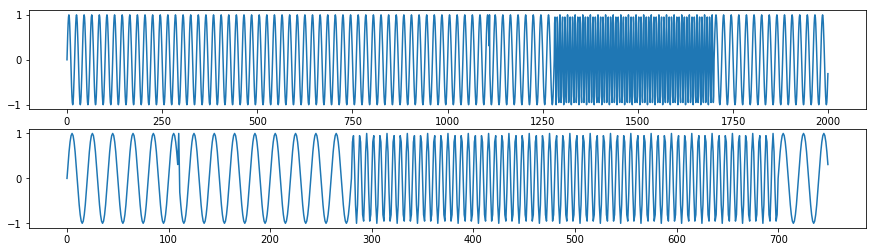

In [15]:
# Like the SDRClassifier, let's run a test on some made-up data
#   We'll make a nice repeating pattern, then throw in a spatial anomaly,
#   then throw in a temporaly anomaly before reverting to the normal pattern

# Make a sine wave with two anomalies
fig, ax = plt.subplots(2,1,figsize=(15,4))
t = np.arange(0,100*2*np.pi,2*np.pi/20)
swave = np.sin(t)
swave[1110] = 1  # spatial anomaly
swave[1280:1700] = np.sin(t[1280:1700]*3)  # temporal anomaly
ax[0].plot(swave)
ax[1].plot(swave[1000:1750],'-') # show anomalies
plt.show()

### Sidebar - A Consideration of Encoding Resolution
I'm going to encode only the y-value with a [RDSE](http://nupic.docs.numenta.org/1.0.5/api/algorithms/encoders.html#nupic.encoders.random_distributed_scalar.RandomDistributedScalarEncoder). But with what resolution? If the resolution is too small, similar values will have no overlap. If the resolution is too big, all the data will be represented by the same encoding (i.e. complete overlag). Both of these properties will propagate into the SP and resulting SDRs. So, to get an idea of the encoder resolution, let's look at the (minimum) resolution of the data.

In [16]:
np.sort(np.unique(np.abs(np.diff(swave[:]))))[0]

0.04894348370482271

Consider for the moment that our number of On bits in our encoder is NE and the number of active columns in our Spatial Pooler is NS. If we choose the minimum difference between consecutive data points as our encoding resolution, then the overlap between two encodings will be NE-1. It would be nice to say that, after the SP creates SDRs from these encodings, the maximum overlap for the two SDRs would be NS-1, but that can't be guaranteed. It's (probably) highly unlikely that the SDRs could have an overlap of NS, but one can imagine it as possible.

Imagine a situation wherein we "move" one bit (turn it off and turn it on elsewhere) in the encoding; this represents a change from one input to one very similar. Given the way the SP is set up, this will only affect columns who have connections to those two bits. If we further postulate that the columns that are active are far above the threshold of the number of On bits to be considered active, then switching that bit off won't change their activity. And if we consider the same is true for the inactive columns who gain an extra On-bit (i.e. the state doesn't change), then the SDR won't change. The code below proved this (for x=0.7 there's an encoding overlap of 20/21 and SDR overlap of 20/20), but it might not work every time (possibly due to the random nature of the potential pool generation?).

In [17]:
encoder = RandomDistributedScalarEncoder(resolution=0.1)
mysp = SpatialPooler(inputDimensions=[400,], columnDimensions=(1024,), globalInhibition=True,
                   numActiveColumnsPerInhArea=20, wrapAround=False)
dummy = np.zeros(mysp.getColumnDimensions()[0])
for x in np.sin(np.linspace(0,100*np.pi,1000)):
    mysp.compute(encoder.encode(x), True, dummy)

Encoding Overlap = 20/21
     SDR Overlap = 20/20


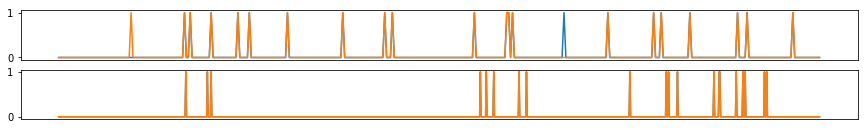

In [18]:
x = 0.7
d1 = encoder.encode(x)
d2 = encoder.encode(x+0.1)
encCols1 = np.nonzero(d1)[0]
encCols2 = np.nonzero(d2)[0]
sdr1 = np.zeros(mysp.getColumnDimensions()[0])
sdr2 = np.zeros(mysp.getColumnDimensions()[0])
mysp.compute(d1, False, sdr1)
mysp.compute(d2, False, sdr2)
sdrCols1 = np.nonzero(sdr1)[0]
sdrCols2 = np.nonzero(sdr2)[0]
fig, ax = plt.subplots(2, 1, figsize=(15,2))
ax[0].plot(range(400),d1,range(400),d2)
ax[1].plot(range(1024),sdr1,range(1024),sdr2)
for a in ax:
    a.set_xticks([])
print("Encoding Overlap = {}/{}".format(len(np.intersect1d(encCols1, encCols2)), len(encCols1)))
print("     SDR Overlap = {}/{}".format(len(np.intersect1d(sdrCols1, sdrCols2)), len(sdrCols1)))
plt.show()

"Ok, fine," you say, "so what encoder resolution $r$ do we choose?" Well, our purpose (here) is to do anomaly detection. So we could ask ourselves, "If my system makes a prediction $P$ (equivalent to a set of columns), but the actual value $A$ (equivalent to another set of columns) differs by $\delta$, how big does $\delta$ need to be before I think $A$ represents an anomaly?"

To use a concrete example, say your learner has learned the sequence 1, 2, 3, 4, 5, 6, 7. The sequence starts coming in, and you get to 5. For the next step, $P$ = 6, but $A$ comes in as 6.4. Do you care? Probably not. What if $A$ came in as 2? You'd probably want that counted as an anomaly.

#### tl;dr -- try starting out with $r = 2\delta/w$, and increase as needed

**Warning**: this analysis assumes you are encoding a single scalar value. It is incorrect if you are encoding other data (e.g. time of day, a category of some sort, etc). A similar approach may be workable for encoding on multi-dimensional data, but we're trying to keep this example simple.

If you choose some encoding resolution $r$, then the _encodings_ for X and X+$r$ will be different. In fact, they will have an overlap of $N-1$ because they are different by exactly the resolution amount. Furthermore, if you look at the encodings for X and Y when X and Y differ by a HUGE amount relative to $r$, then the encodings will have NO overlap. The important question is, what is the overlap between **the SDRs** created from the encodings of X, X+$r$, and Y? Well, SDRs are supposed to preserve semantic meaning, so the SDR overlap for X and X+$r$ should be _very_ high, and the SDR overlap for Y and either of the other two should be _very_ low. In other words, the encoding overlap is proportional to the SDR overlap.

Only _high_ anomaly scores can possibly produce high anomaly likelihoods (it's in [the way the calculation is done](http://nupic.docs.numenta.org/1.0.5/api/algorithms/anomaly-detection.html#nupic.algorithms.anomaly_likelihood.AnomalyLikelihood.anomalyProbability); gauss distribution estimation; [area under outer tail](https://github.com/numenta/nupic/blob/50c5fd0dc94f2ffb205544ed11fe82ad5bb0de18/src/nupic/algorithms/anomaly_likelihood.py#L742)). Remember, the anomaly score is the relative percentage of unpredicted columns. If you missed $M$ columns out of a possible $N$, your score would be $M/N$ (e.g. if 10 columns out of 40 were unpredicted, your score would be $10/40=0.25$). This indicates that if you know the number of active spatial pooler columns $N$, then for a given anomaly score $S$ you can calculate the number of unpredicted columns as $NS$.

As your prediction $P$ moves away from the actual value $A$, you will gain more unpredicted columns. How many? If $P$ and $A$ differ by $r$, you know the _encodings_ will differ by one bit. In fact, if you differ by $\delta$, you will differ by $\delta/r$ bits, with one caveat: you can't differ by more than your encoder's bucket size ($w$).

Taking into account SDRs preserving semantic meaning, the number of unpredicted columns _should_ be proportional to the number of missed bits, i.e. $C*\delta/r$. (As we saw above, this might not always be perfect in every case, but in general this must be true, otherwise semantic meaning is NOT being preserved.) Now we just need to figure out $C$. If $P$ and $A$ encodings differ by zero bits, you should have zero unpredicted columns. If you differ by $w$ bits, you should have $N$ unpredicted columns. Assuming a linear relationship in between, we set $C = N/w$.

So now we can equate the two formulas for unpredicted columns. Namely, $NS = N\delta/(wr)$ which gives us $r = \delta/(wS)$. Because only high anomaly scores can produce high anomaly likelihoods, let's restrict the anomaly scores produced by differences $|P-A|<\delta$. Arbitrarily, we choose to limit these differences to having scores $S<0.5$. This leaves us with $r = 2\delta/w$.

### Running Anomaly Detection on a Sine Wave

We've already created the data we'll use. Now we just need to run through the encoding, SP, and TM parts, then do some anomaly detection. For our purposes here, we'll use the `Anomaly` and `AnomalyLikelihood` classes for convenient calculations. Their parameters are copied [from here](http://nupic.docs.numenta.org/1.0.5/api/algorithms/anomaly-detection.html).

### Anomaly parameters

**slidingWindowSize** - (int) - how many elements are summed up; enables moving average on final anomaly score. *Default None*

**mode** - (str) - how to compute anomaly; valid values are '*likelihood*', '*pure*', and '*weighted*'. *Default 'pure'*

>'likelihood': Uses the AnomalyLikelihood class, which models probability of receiving this value and anomalyScore  
'pure': The raw anomaly score, computed as fraction of active columns not predicted  
'weighted': Multiplies the likelihood result with the raw anomaly score that was used to generate the likelihood (anomaly * likelihood)

**binaryAnomalyThreshold** - (float) - if set, the anomaly score will be discretized to 0 or 1 (1 if >= setting). The transformation is applied after the moving average is computed. Valid range is [0,1]. *Default None*

### AnomalyLikelihood parameters

**learningPeriod** - (int) - the number of iterations required for the algorithm to learn the basic patterns in the dataset and for the anomaly score to 'settle down'. The default is based on empirical observations but in reality this could be larger for more complex domains. The downside if this is too large is that real anomalies might get ignored and not flagged. *Default 288*

**estimationSamples** - (int) - the number of reasonable anomaly scores required for the initial estimate of the Gaussian. The default of 100 records is reasonable - we just need sufficient samples to get a decent estimate for the Gaussian. It's unlikely you will need to tune this since the Gaussian is re-estimated every 100 iterations by default. *Default 100*

**historicWindowSize** - (int) - size of sliding window of historical data points to maintain for periodic reestimation of the Gaussian. Note: the default of 8640 is based on a month's worth of history at 5-minute intervals. *Default 8640*

**reestimationPeriod** - (int) - how often we re-estimate the Gaussian distribution. The ideal is to re-estimate every iteration but this is a performance hit. In general the system is not very sensitive to this number as long as it is small relative to the total number of records processed. *Default 100*

NOTE: Anomaly likelihood scores are reported at a flat 0.5 for the first **learningPeriod** + **estimationSamples** iterations.

In [19]:
def run(returnResults=False, resolution=0.05, historicWindowSize=2500, slidingWindowSize=0):
    aScore = Anomaly(slidingWindowSize=slidingWindowSize)
    aLikely = AnomalyLikelihood(historicWindowSize=historicWindowSize)

    # Create our encoder, spatial pooler, and temporal memory
    encoder = RandomDistributedScalarEncoder(resolution=resolution)
    sp = SpatialPooler(
        inputDimensions = (encoder.getWidth(),),
        columnDimensions=(2048,),
        potentialRadius = encoder.getWidth(),
        potentialPct = 0.85,
        globalInhibition = True,
        localAreaDensity = -1.0,
        numActiveColumnsPerInhArea = 40.0,
        stimulusThreshold = 0,
        synPermInactiveDec = 0.005,
        synPermActiveInc = 0.04,
        synPermConnected = 0.1,
        minPctOverlapDutyCycle = 0.001,
        dutyCyclePeriod = 100,
        boostStrength = 3.0,
        seed = 42,
        spVerbosity = 0,
        wrapAround = False)
    tm = TemporalMemory(
        columnDimensions = sp.getColumnDimensions(),
        cellsPerColumn = 16,
        activationThreshold = 16,
        initialPermanence = 0.55,
        connectedPermanence = 0.5,
        minThreshold = 12,
        maxNewSynapseCount = 20,
        permanenceIncrement = 0.1,
        permanenceDecrement = 0.1,
        predictedSegmentDecrement = 0.0,
        seed = 42,
        maxSegmentsPerCell = 128,
        maxSynapsesPerSegment = 40)
    tm.predictedSegmentDecrement = sp.getNumActiveColumnsPerInhArea() / sp.getColumnDimensions()[0] * tm.permanenceIncrement

    # Let the SP learn the data it has to represent
    activeCols = np.zeros(sp.getColumnDimensions()[0])
    for s in swave[:1000]:
        sp.compute(encoder.encode(s), True, activeCols)
    
    scores = np.zeros(len(swave))
    hoods = np.zeros(len(swave))
    loghoods = np.zeros(len(swave))
    for i,v in enumerate(swave):
        if i % 20 == 0: # reset when the sine wave starts again
            tm.reset()
        sp.compute(encoder.encode(v), False, activeCols)
        predColIndices = [tm.columnForCell(cell) for cell in tm.getPredictiveCells()]
        activeColIndices = np.nonzero(activeCols)[0]
        tm.compute(activeColIndices, learn=True)
        scores[i] = aScore.compute(activeColIndices, predColIndices)
        hoods[i] = aLikely.anomalyProbability(v, scores[i])
        loghoods[i] = aLikely.computeLogLikelihood(hoods[i])

    fig, ax = plt.subplots(3,1,figsize=(15,2*3))
    ax[0].plot(hoods,label="normal")
    ax[0].plot(loghoods, label="log")
    ax[1].plot(scores)
    ax[2].plot(swave)
    ax[0].set_ylabel('Anomaly\nLikelihoods')
    ax[1].set_ylabel('Anomaly\nScore')
    ax[2].set_ylabel('Sine wave')
    ax[0].set_title("res={}, histWS={}, anomSW={}".format(resolution, historicWindowSize, slidingWindowSize), fontsize=16)
    ax[0].grid()
    ax[0].legend()
    ax[1].legend()
    for ax in ax[:2]:
        ax.set_ylim((0,1.05))
    plt.show()
    if returnResults:
        return scores, hoods, loghoods

Now that we have our function ready to go, we can run a bunch of different scenarios and see how the anomaly detection changes. I chose to vary the encoding **resolution**, the **historicWindowSize** of the `AnomalyLikelihood` class, and the **slidingWindowSize** of the `Anomaly` class.

#### Results
**resolution**: Looking at the anomaly score as an indication of how quickly the TM learned the sequence, it appears 0.01 caused the TM to learn the sequence fastest; with the others, it took longer. The anomaly detection was thwarted by a resolution of 1, as expected. For all other resolutions, the anomalies were always detected (likelihood >= 0.5). The log likelihood was most pronounced for a resolution of 0.1.

**historicWindowSize**: This affected the anomaly likelihoods as expected. Larger windows prolonged the memory of an anomaly (high likelihoods) while smaller windows forgot about anomalies faster.

**slidingWindowSize**: This smoothed the likelihoods nicely when set to 20 (which makes some sense since the sequence is 20 points long).

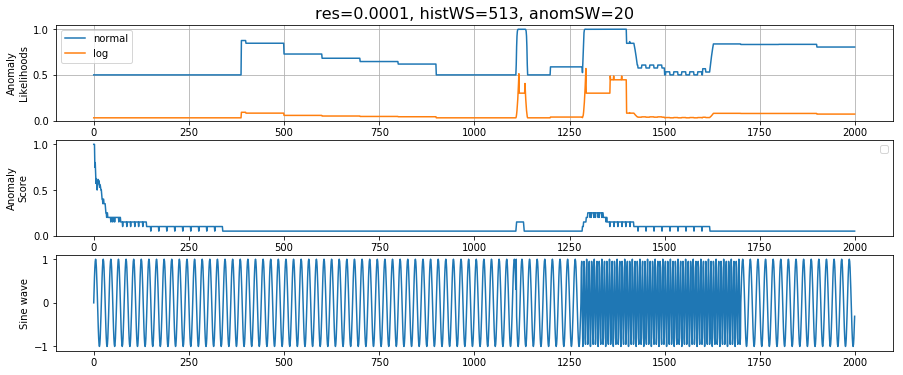

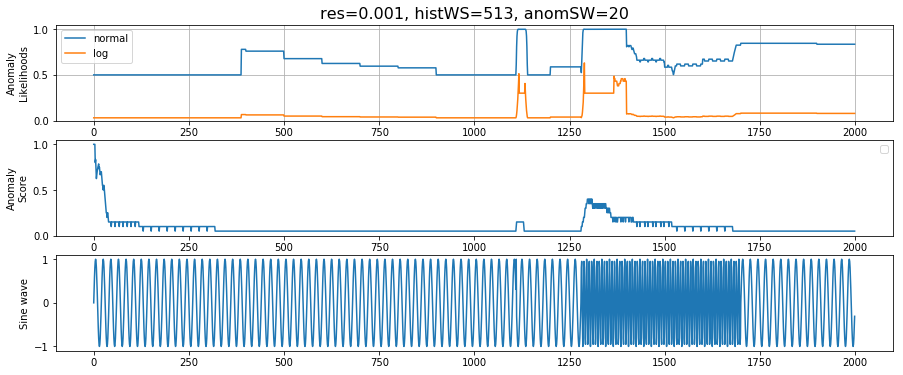

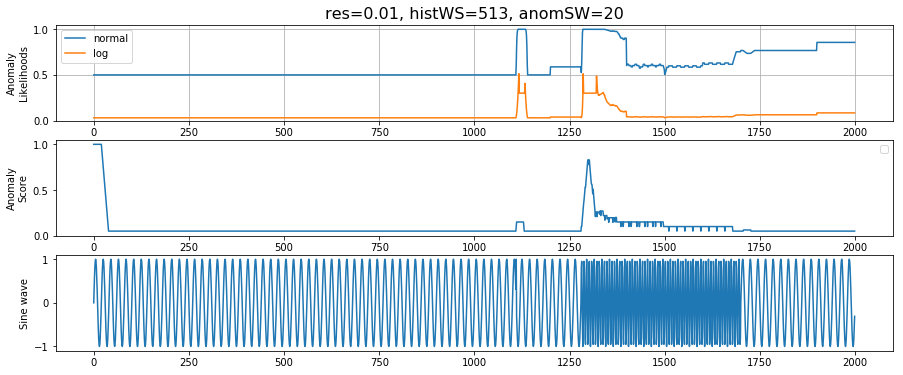

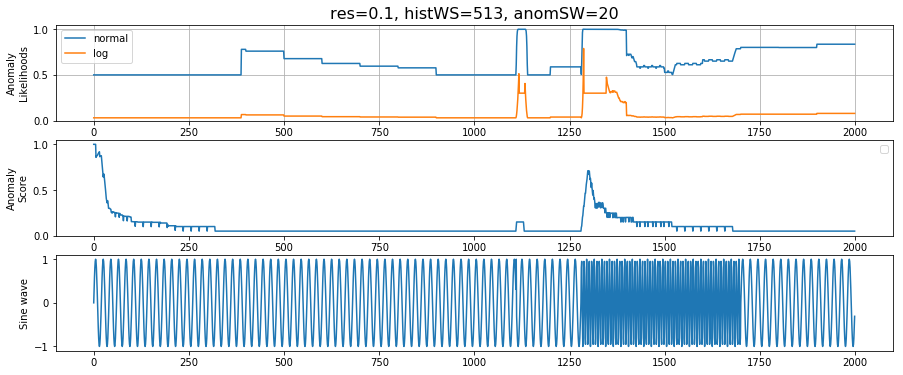

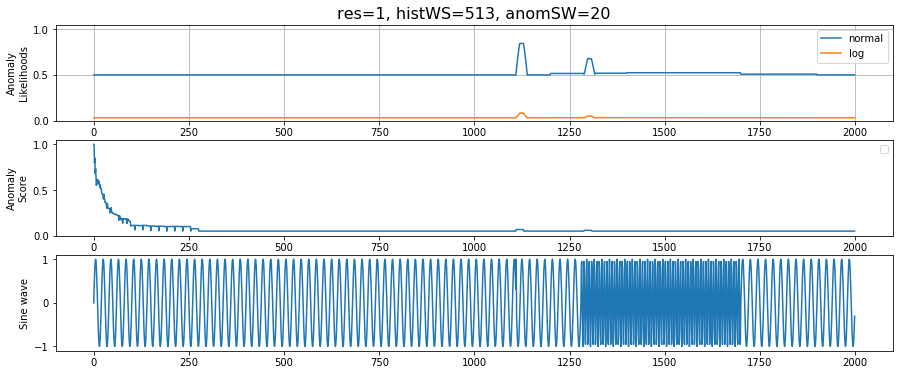

In [20]:
for r in (0.0001, 0.001, 0.01, 0.1, 1):
    run(resolution=r, historicWindowSize=513, slidingWindowSize=20)

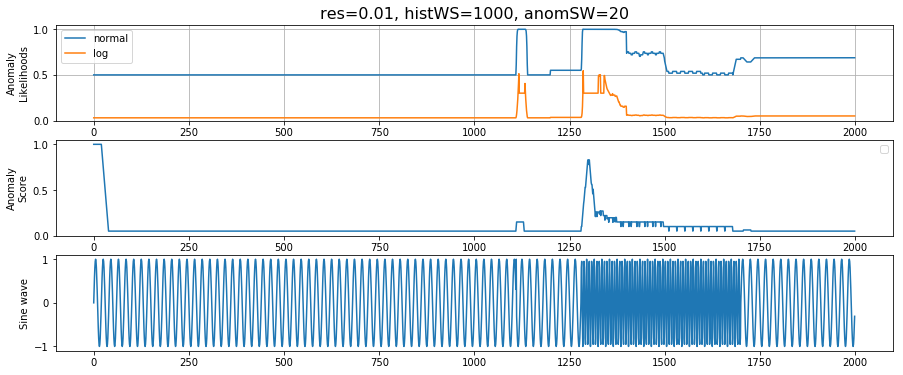

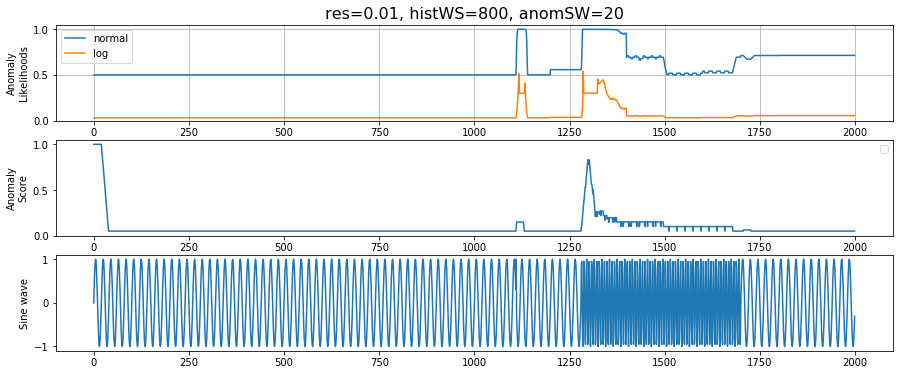

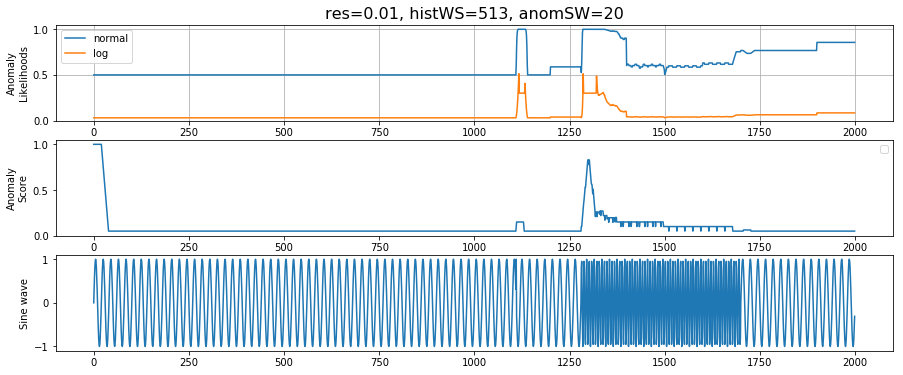

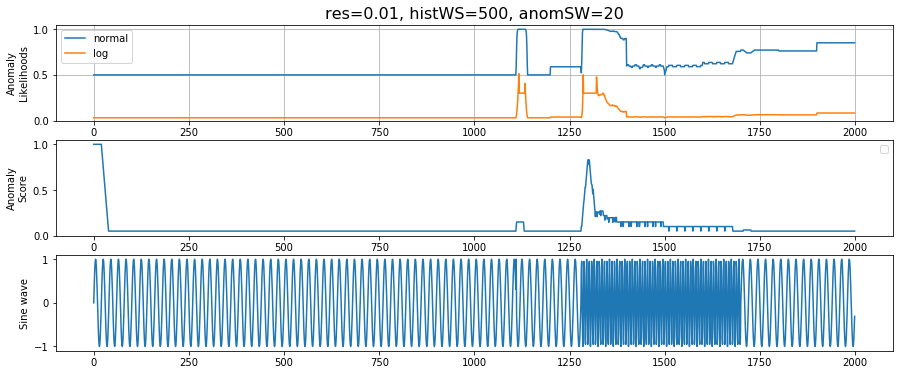

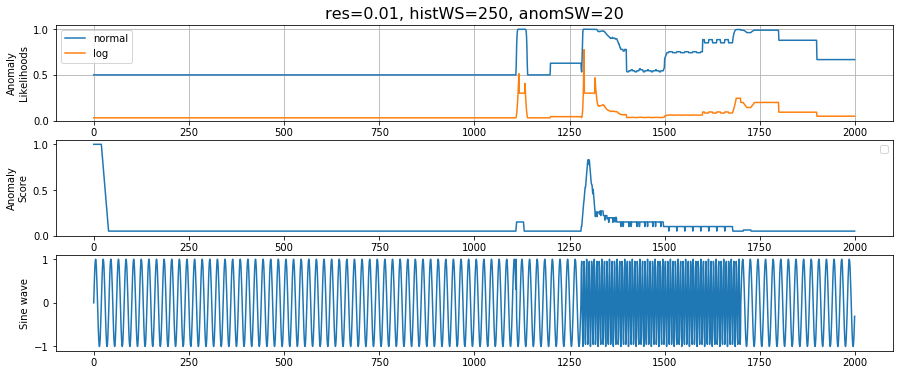

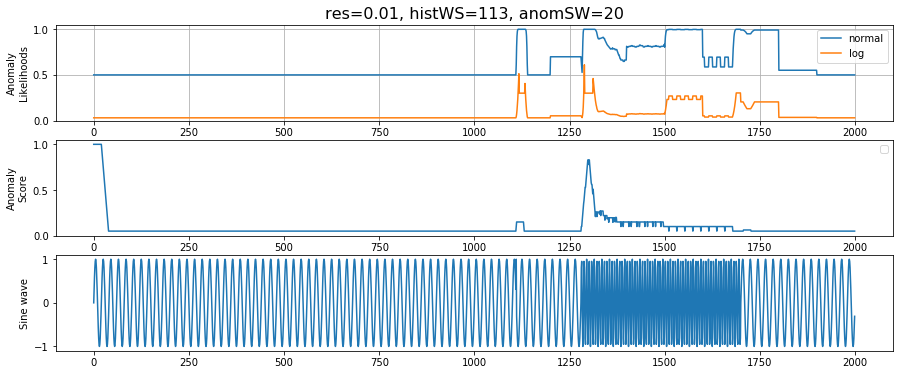

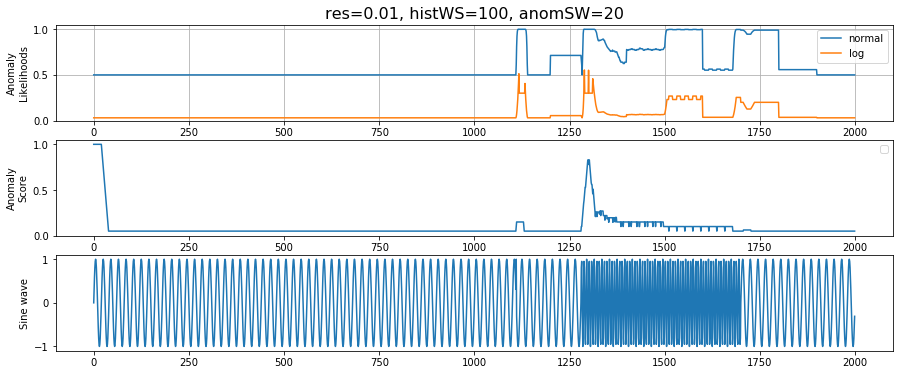

In [21]:
for h in (1000, 800, 513, 500, 250, 113, 100):
    run(resolution=0.01, historicWindowSize=h, slidingWindowSize=20)

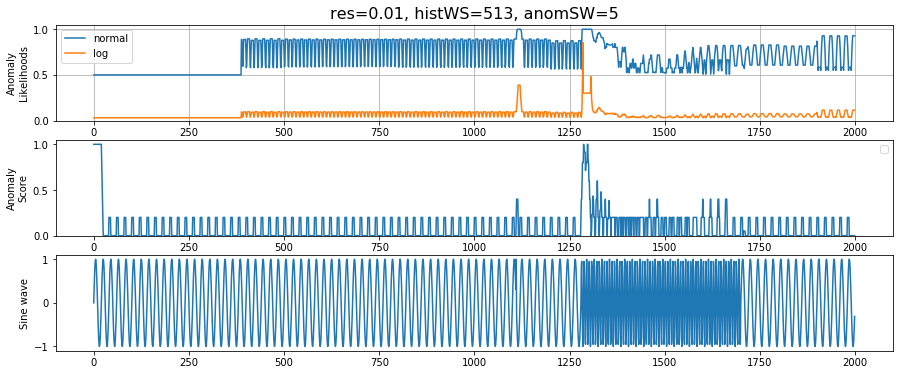

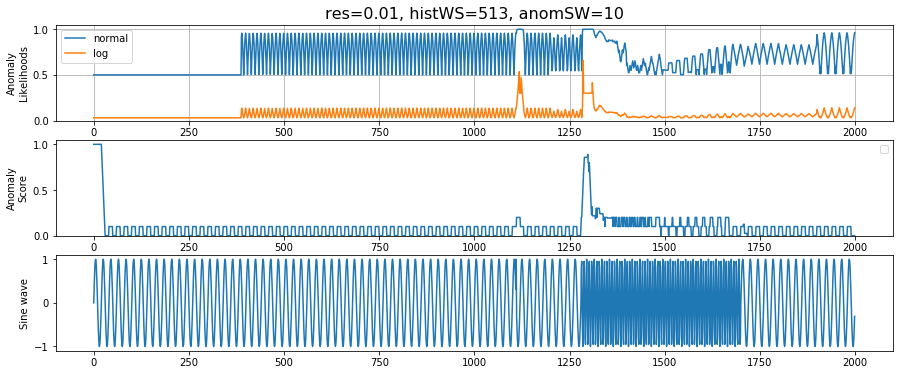

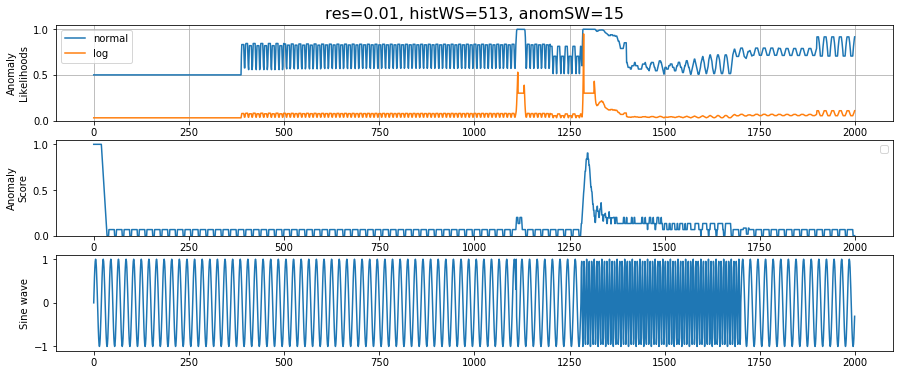

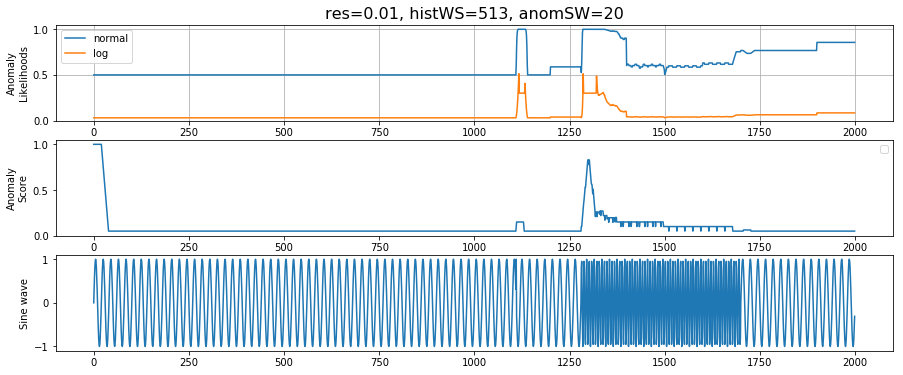

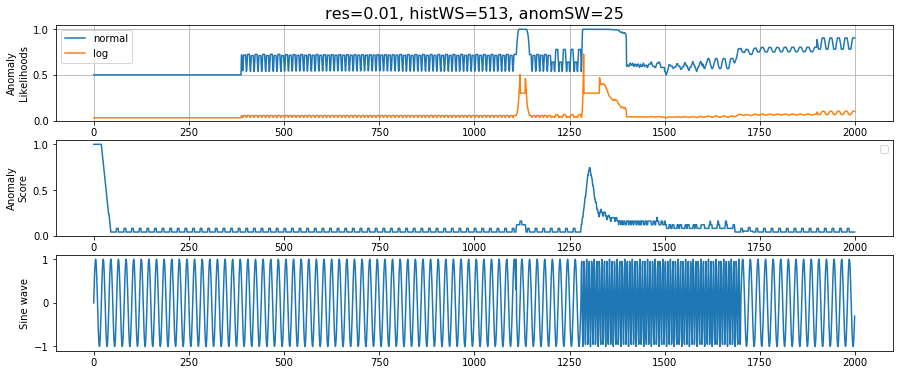

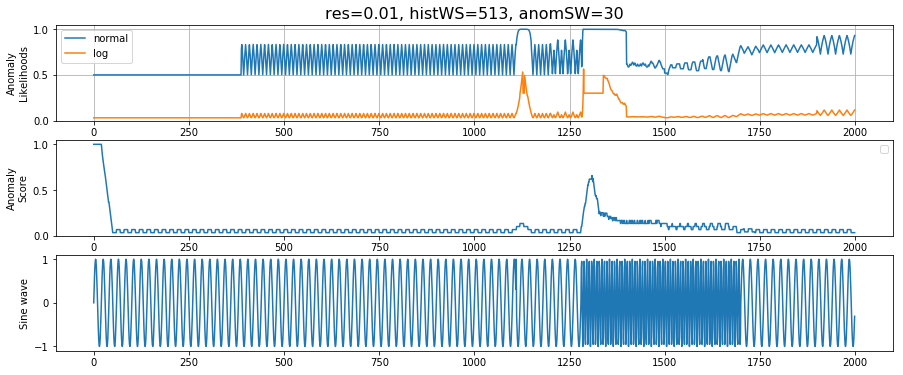

In [22]:
for w in (5, 10, 15, 20, 25, 30):
    run(resolution=0.01, historicWindowSize=513, slidingWindowSize=w)

## Putting It All Together
Now we'll combine all the parts into one example. We'll use the favorite One Hot Gym data for NuPIC beginners.

### Encoding
We'll use three encoders like we did in [the beginning](#Encoding-Data). From the [discussion on choosing the resolution for a RDSE](#Sidebar---A-Consideration-of-Encoding-Resolution), we know that the analysis is not applicable because final encoding is not that of only a single scalar value. Instead, we need to think a little differently.

One option would be to choose the minimum resolution of the data. In this case, we would choose 0.1. A second option would be to consider if there is noise in the data. Meaning, how precise are the reported numbers? If the consumption is reported as 43.2, for example, is that 43.2 $\pm$ 0.1? $\pm$ 0.5? $\pm$ 1.0? Of the two options, taking noise into consideration makes the most sense as it nicely parallels the way encoders bin together similar values. For now, I'm going to take a wild guess and choose a resolution of 0.5.

### Spatial Pooler and Temporal Memory
In this case, I'm going to turn on boosting while the SP is learning the domain. After it's done, I'll turn boosting off. I'm not doing anything special with the TM setup.

### Classification and Anomaly Detection
For the classifier, I'm setting the prediction steps to 1, and the alpha to 0.01 (which should make it learn faster than the default of 0.001). I'm also preventing the classifier from learning anything until the TM has seen 500 records (~21 days). For the anomaly scores, I'm averaging them over 25 hours. For the anomaly likelihoods, I'm setting the initial learning period to 600 (25 days) and the historic window size to 336 (14 days).

The code below will create the following numpy arrays that we can use for analysis/plotting later:
>consumption: energy consumption  
predictions: prediction of energy consumption  
ascores: anomaly scores  
alhoods: anomaly likelihoods  
alloghoods: anomaly log likelihoods

In [23]:
_NUM_RECORDS = 4390

print("Creating encoders and encodings...")
timeOfDayEncoder = DateEncoder(timeOfDay=(21,1))
weekendEncoder = DateEncoder(weekend=21)

scalarEncoder = RandomDistributedScalarEncoder(resolution=0.5)

encodingWidth = timeOfDayEncoder.getWidth() + weekendEncoder.getWidth() + scalarEncoder.getWidth()

timeOfDayBits = np.zeros(timeOfDayEncoder.getWidth())
weekendBits = np.zeros(weekendEncoder.getWidth())
consumptionBits = np.zeros(scalarEncoder.getWidth())

activeColumns = np.zeros(2048)

print("Initializing Spatial Pooler...")
sp = SpatialPooler(
    inputDimensions = (encodingWidth,),
    columnDimensions=(2048,),
    potentialRadius = encodingWidth, # global coverage
    potentialPct = 0.85,
    globalInhibition = True,
    localAreaDensity = -1.0,
    numActiveColumnsPerInhArea = 40.0, # %2 sparsity
    stimulusThreshold = 0,
    synPermInactiveDec = 0.005,
    synPermActiveInc = 0.04,
    synPermConnected = 0.1,
    minPctOverlapDutyCycle = 0.001,
    dutyCyclePeriod = 100,
    boostStrength = 3.0, # boost a little
    seed = 42,
    spVerbosity = 0,
    wrapAround = False
)

print("Letting the spatial pooler learn the dataspace...")
n_train_for_SP = 3000
with open(_INPUT_FILE_PATH, 'r') as fin:
    reader = csv.reader(fin)
    reader.next() # ignore the headers
    reader.next()
    reader.next()
    for count, record in enumerate(reader):
        if count >= n_train_for_SP: break
        dateString = dt.strptime(record[0], "%m/%d/%y %H:%M")
        consumption = float(record[1])
        timeOfDayEncoder.encodeIntoArray(dateString, timeOfDayBits)
        weekendEncoder.encodeIntoArray(dateString, weekendBits)
        scalarEncoder.encodeIntoArray(consumption, consumptionBits)
        encoding = np.concatenate([timeOfDayBits, weekendBits, consumptionBits])
        sp.compute(encoding, True, activeColumns)

print("...all done. Turning off boosting")
sp.setBoostStrength(0.0)

print("Initializing Temporal Memory...")
tm = TemporalMemory(
    columnDimensions = sp.getColumnDimensions(),
    cellsPerColumn = 16,
    activationThreshold = 13,
    initialPermanence = 0.55,
    connectedPermanence = 0.5,
    minThreshold = 10,
    maxNewSynapseCount = 20,
    permanenceIncrement = 0.1,
    permanenceDecrement = 0.1,
    predictedSegmentDecrement = 0.0,
    seed = 42,
    maxSegmentsPerCell = 128,
    maxSynapsesPerSegment = 40
)

print("Initializing classification and anomaly calculators")
classifier = SDRClassifierFactory.create(steps=[1], alpha=0.01)
predictions = np.zeros(_NUM_RECORDS+2)

aScore = Anomaly(slidingWindowSize=25)
aLikely = AnomalyLikelihood(learningPeriod=600, historicWindowSize=313)
ascores = np.zeros(_NUM_RECORDS+1)
alhoods = np.zeros(_NUM_RECORDS+1)
alloghoods = np.zeros(_NUM_RECORDS+1)

with open(_INPUT_FILE_PATH, "r") as fin:
    reader = csv.reader(fin)
    reader.next()
    reader.next()
    reader.next()

    print("Beginning record processing...")
    for count, record in enumerate(reader):

        if count > _NUM_RECORDS: break
        if count % 500 == 0:
            print("...processed {0:4d}/{1} records...".format(count, _NUM_RECORDS))

        dateString = dt.strptime(record[0], "%m/%d/%y %H:%M")
        consumption = float(record[1])
        timeOfDayEncoder.encodeIntoArray(dateString, timeOfDayBits)
        weekendEncoder.encodeIntoArray(dateString, weekendBits)
        scalarEncoder.encodeIntoArray(consumption, consumptionBits)
        encoding = np.concatenate([timeOfDayBits, weekendBits, consumptionBits])

        sp.compute(encoding, False, activeColumns)
        activeColumnIndices = np.nonzero(activeColumns)[0]
        predictedColumnIndices = [tm.columnForCell(cell) for cell in tm.getPredictiveCells()]
        tm.compute(activeColumnIndices, learn=True)
        ascores[count] = aScore.compute(activeColumnIndices, predictedColumnIndices)
        alhoods[count] = aLikely.anomalyProbability(consumption, ascores[count])
        alloghoods[count] = aLikely.computeLogLikelihood(alhoods[count])

        bucketIdx = scalarEncoder.getBucketIndices(consumption)[0]
        classifierResult = classifier.compute(recordNum=count, patternNZ=tm.getActiveCells(),
            classification={"bucketIdx": bucketIdx,"actValue": consumption},
            learn=count > 500, # let classifier learn once TM has learned a little
            infer=True
        )

        predConf, predictions[count+1] = sorted(zip(classifierResult[1], classifierResult["actualValues"]), reverse=True)[0]

consumption = np.loadtxt(_INPUT_FILE_PATH,delimiter=',',skiprows=3,usecols=1)

Creating encoders and encodings...
Initializing Spatial Pooler...
Letting the spatial pooler learn the dataspace...
...all done. Turning off boosting
Initializing Temporal Memory...
Initializing classification and anomaly calculators
Beginning record processing...
...processed    0/4390 records...
...processed  500/4390 records...
...processed 1000/4390 records...
...processed 1500/4390 records...
...processed 2000/4390 records...
...processed 2500/4390 records...
...processed 3000/4390 records...
...processed 3500/4390 records...
...processed 4000/4390 records...


Alright, let's see what we got. But before we do, let's look at the data and see if we can pick out any anomalies.

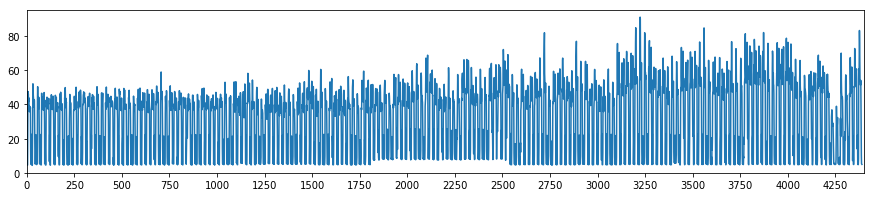

In [24]:
plt.figure(figsize=(15,3))
plt.plot(consumption)
plt.xlim(0, 4400)
plt.xticks(range(0,4401,250))
plt.show()

So, if I had to guess, I'd say three things pop out as potential anomalies. First, the consumption doesn't return to its normal baseline somewhere between 1800 and 2550. Second, there seems to be an uncharacteristic increase in consumption around 3250. Finally, there's a strange dip near 4250. Let's see what our code found.

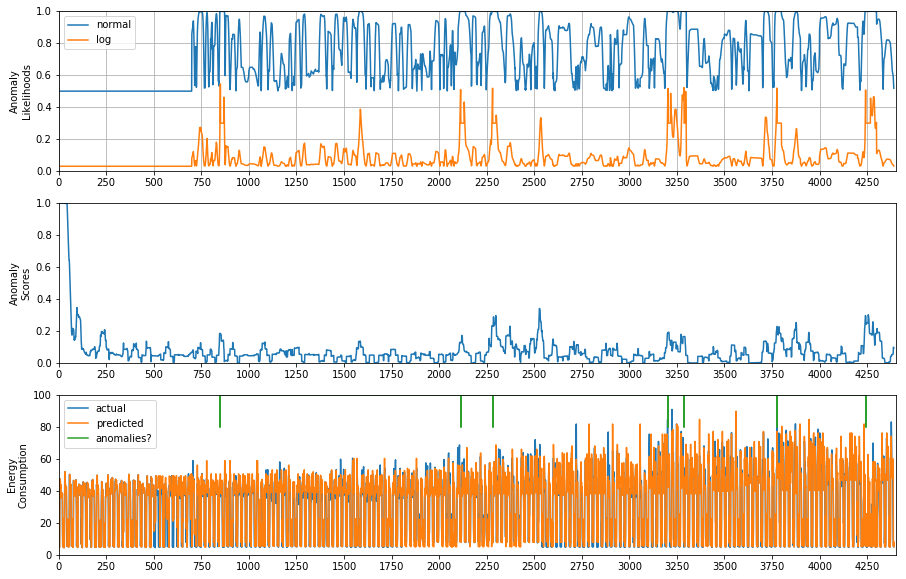

In [25]:
possible_anomaly_indices = np.where(alloghoods >= 0.5)[0]
y = np.array([100,80,100]*len(possible_anomaly_indices))
possible_anomaly_indices = np.sort(np.concatenate((possible_anomaly_indices, possible_anomaly_indices, possible_anomaly_indices)))
fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0].plot(alhoods, label='normal')
ax[0].plot(alloghoods, label='log')
ax[1].plot(ascores)
ax[2].plot(consumption, label='actual')
ax[2].plot(predictions, label='predicted')
ax[2].plot(possible_anomaly_indices, y, label='anomalies?')
ax[0].grid()
for a in ax:
    a.set_xlim((0,4400))
    a.set_xticks(range(0,4401,250))
ax[0].set_ylim((0,1))
ax[1].set_ylim((0,1))
ax[2].set_ylim((0,100))
ax[0].legend()
ax[2].legend()
ax[0].set_ylabel("Anomaly\nLikelihoods")
ax[1].set_ylabel("Anomaly\nScores")
ax[2].set_ylabel("Energy\nConsumption")
plt.show()

So our code found 7 anomalies, but only 3 of them correspond to our predictions. Let's zoom in on some of the areas and see what the actual vs predicted consumptions look like.

In [26]:
def zoom(N, w=150):
    plt.figure(figsize=(15,3))
    plt.plot(consumption[N-w:N+w], label="actual")
    plt.plot(predictions[N-w:N+w], label="predicted")
    plt.plot([w, w], [0, 100], label="anomaly")
    plt.xlim((0,w))
    plt.xticks(range(0,301,10))
    plt.title("Centered at anomaly index {}".format(N))
    plt.show()

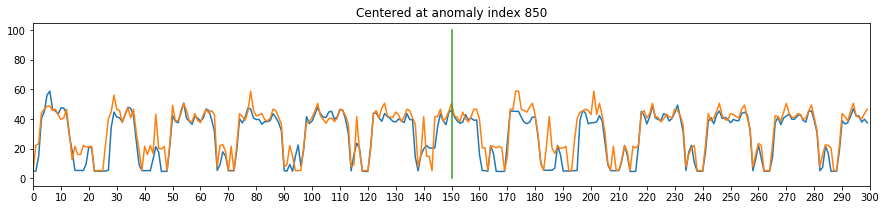

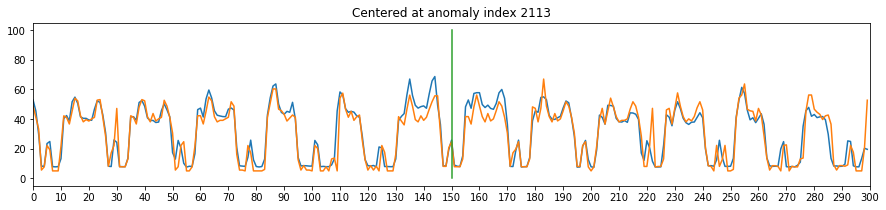

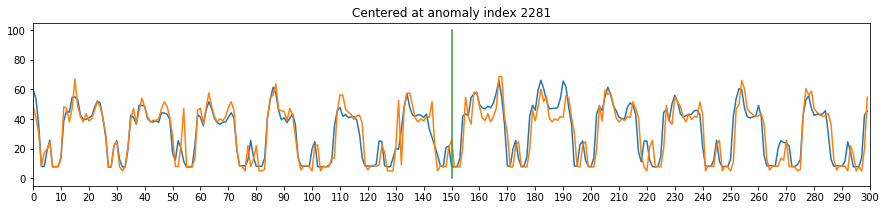

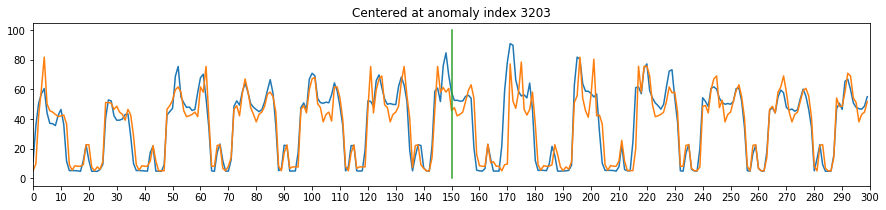

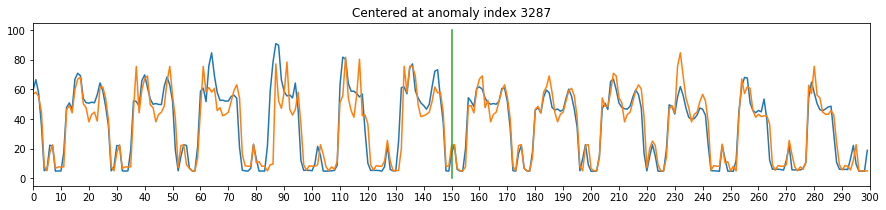

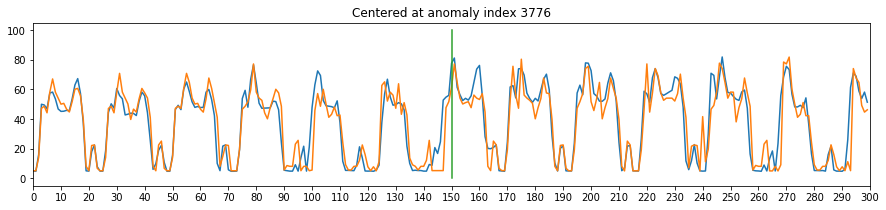

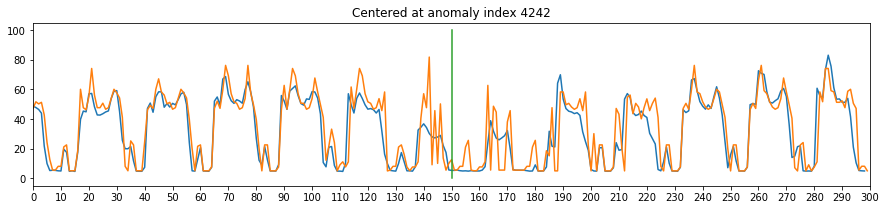

In [27]:
for i in np.unique(possible_anomaly_indices):
    zoom(i)

To be sure, what we're doing here is definitely inappropriate if one is doing proper model evaluation. One doesn't run a model, then figure out why one's model is correct by seeking out explanations for all the places it got wrong and declare the model perfect. This is purely an exploratory exercise.

| Index | Date and Time | Weekday | Possible reason for flagging |
|-|-|-|-|
|850 |8/6    9:00| Friday   | Consumption doesn't return to zero at 141-143 |
|2113|9/28   0:00| Tuesday  | Increased consumption over 131-144 |
|2281|10/5   0:00| Tuesday  | No idea |
|3203|11/12 10:00| Friday   | Increased consumption that day |
|3287|11/15 22:00| Monday   | Increased consumption that evening |
|3776|12/6   7:00| Monday   | No idea |
|4242|12/25 17:00| Saturday | Decreased consumption that day (and the next!) |

It makes sense that there would be low consumption on Christmas; few people would go to the gym that day.

Since we're already committing sacrilegious acts, let's look at the data in one final way. If we were doing this for real, we would have done this at the beginning, during the "explore your data" phase of any ML project. I want to look at curves of the consumption at the same hour every day. For instance, I would expect that every day at noon, the consumption is roughly the same (because the gym is open every day at noon). However, seeing as consumption during weekdays seems to longer than weekends, maybe a time like 18:00 would be high during weekdays and low during weekends (e.g. because maybe the gym closes before 18:00 on weekends).

These curves will give us another way of looking at what happened over the year. Each plot below is the power consumption at that time of the day (label on the right) for the days spanning July 2, 2010 to December 31, 2010. The middle of the time span is October 1. The vertical lines are where anomalies were detected.

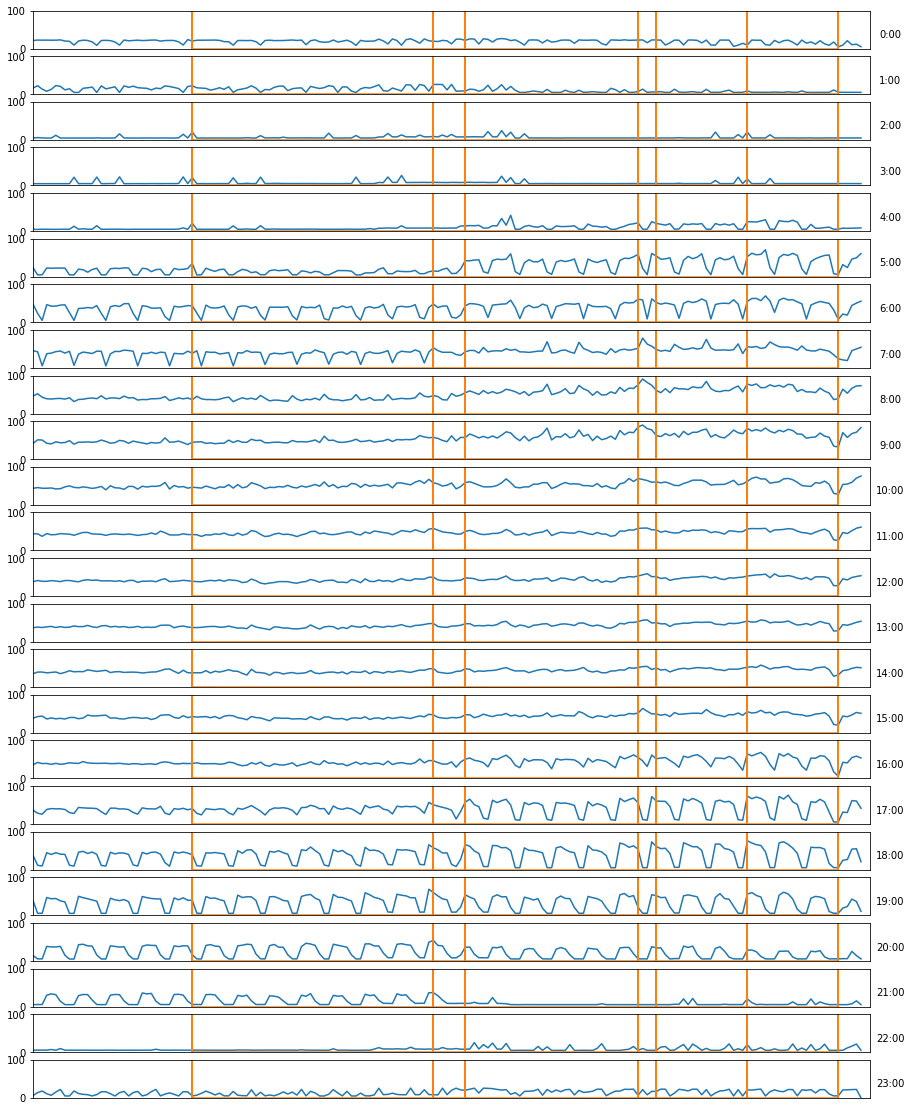

In [28]:
# Create the aforementioned curves
hour = dict.fromkeys(range(24))
counts = np.zeros(24,dtype=int)
for h in range(24):
    hour[h] = np.zeros(183)

with open(_INPUT_FILE_PATH,'r') as fin:
    reader = csv.reader(fin)
    reader.next()
    reader.next()
    reader.next()
    for rec in reader:
        h = int(rec[0].split()[1].split(':')[0])
        hour[h][counts[h]] = float(rec[1])
        counts[h] += 1

ind = np.round(np.unique(possible_anomaly_indices)/24)
y = [0,100,0]*len(ind)
ind = np.sort(np.concatenate((ind, ind, ind)))
fig, ax = plt.subplots(24,1,figsize=(15,20))
for i in range(24):
    ax[i].plot(hour[i])
    ax[i].plot(ind, y)
    ax[i].set_xlim((0,184))
    ax[i].set_ylim((0,100))
    ax[i].set_ylabel("{}:00".format(i), rotation=0, labelpad=20)
    ax[i].yaxis.set_label_position("right")
    ax[i].tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.show()

Here are some observations:
1. Some curves are basically flat, while others have periodic dips. These dips are the weekends. If the dip is only one point, it appears to be a Sunday.
2. Around Oct 1 we see pronounced changes in the 5:00, 7:00, 16:00, 17:00, and 21:00 curves  
    1. 5:00 shows a transition to increased power consumption on weekdays
    2. 7:00 shows a transition to increased power consumption on Sundays
    3. 16:00 shows a transition to decreased power consumption on Sundays
    4. 17:00 shows a transition to decreased power consumption on weekends
    5. 21:00 shows a transition to decreased power consumption on weekdays
3. There is a dip on Dec 25 and Dec 26 for all curves from 5:00 to 19:00

Observation #2 gives a nice reason why we saw anomalies around index 3200 above. It appears the gym changed its opening and closing times around that time. In particular, they are now open Sundays at 7:00, and during weekdays they now open at 5:00. On the other end, weekend hours used to go to 17:00, but now they're closing starting at 16:00. Likewise, on weekdays they were open until 21:00, but now they're closed by then.

So that's pretty cool. It found some anomalies we didn't see originally (though again, we should have if we were doing this properly)!

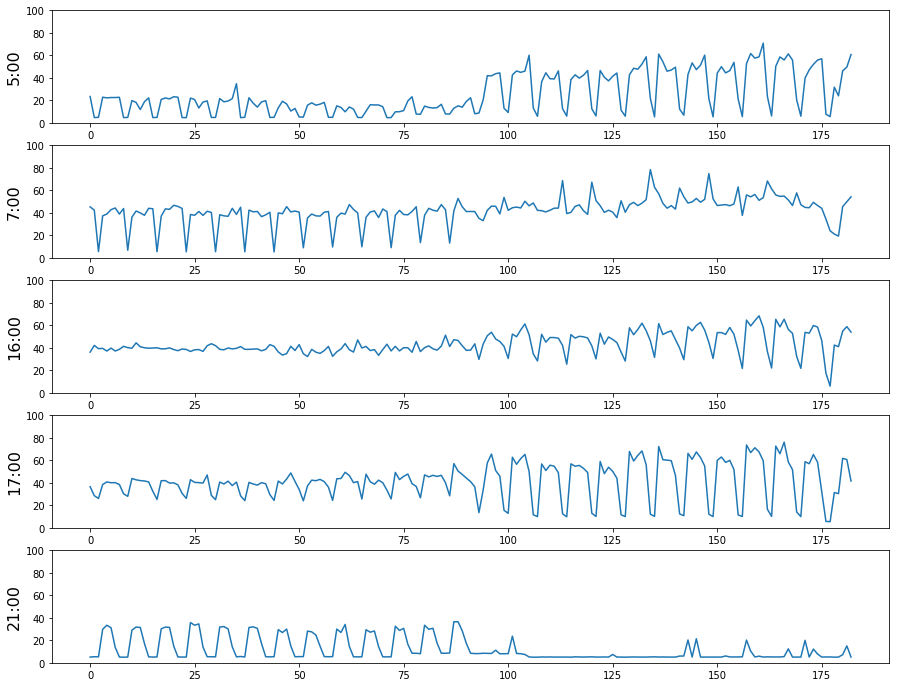

In [29]:
# This is a plot of only the interesting curves
fig, ax = plt.subplots(5,1,figsize=(15,12))
ax[0].plot(hour[5]); ax[0].set_ylim((0,100)); ax[0].set_ylabel("5:00",fontsize=16)
ax[1].plot(hour[7]); ax[1].set_ylim((0,100)); ax[1].set_ylabel("7:00",fontsize=16)
ax[2].plot(hour[16]); ax[2].set_ylim((0,100)); ax[2].set_ylabel("16:00",fontsize=16)
ax[3].plot(hour[17]); ax[3].set_ylim((0,100)); ax[3].set_ylabel("17:00",fontsize=16)
ax[4].plot(hour[21]); ax[4].set_ylim((0,100)); ax[4].set_ylabel("21:00",fontsize=16)
plt.show()

I'll leave you with a suggestion if you want to get your hands dirty (and I encourage you to). I looked at the data in two ways:  energy consumption over the entire year, and energy consumption at a specific hour over the entire year. What anomalies might you find if you looked at energy consumption over each day of the week separately? Meaning, extract all the data from the first Monday of the year, append the data from the second Monday of the year, and so on. I honestly don't know if there's anything to be found, but I figured I'd leave something for you to explore.

If you've made it this far and followed everything, congratulations. Hopefully you've gotten something out of this that you didn't know already. This is a truly fascinating subject, and we need more people to chew on it so we can push this further and welcome our A.I. overlords. Good luck!